**Chapter 16 – Natural Language Processing with RNNs and Attention**

_This notebook contains all the sample code in chapter 16._

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/ageron/handson-ml2/blob/master/16_nlp_with_rnns_and_attention.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
</table>

# Setup

First, let's import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures. We also check that Python 3.5 or later is installed (although Python 2.x may work, it is deprecated so we strongly recommend you use Python 3 instead), as well as Scikit-Learn ≥0.20 and TensorFlow ≥2.0.

In [ ]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    !pip install -q -U tensorflow-addons
    !pip install -q -U transformers
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "nlp"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

No GPU was detected. LSTMs and CNNs can be very slow without a GPU.


# Char-RNN

## Splitting a sequence into batches of shuffled windows

For example, let's split the sequence 0 to 14 into windows of length 5, each shifted by 2 (e.g.,`[0, 1, 2, 3, 4]`, `[2, 3, 4, 5, 6]`, etc.), then shuffle them, and split them into inputs (the first 4 steps) and targets (the last 4 steps) (e.g., `[2, 3, 4, 5, 6]` would be split into `[[2, 3, 4, 5], [3, 4, 5, 6]]`), then create batches of 3 such input/target pairs:

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

n_steps = 5
dataset = tf.data.Dataset.from_tensor_slices(tf.range(15))
dataset = dataset.window(n_steps, shift=2, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(n_steps))
dataset = dataset.shuffle(10).map(lambda window: (window[:-1], window[1:]))
dataset = dataset.batch(3).prefetch(1)
for index, (X_batch, Y_batch) in enumerate(dataset):
    print("_" * 20, "Batch", index, "\nX_batch")
    print(X_batch.numpy())
    print("=" * 5, "\nY_batch")
    print(Y_batch.numpy())

____________________ Batch 0 
X_batch
[[6 7 8 9]
 [2 3 4 5]
 [4 5 6 7]]
===== 
Y_batch
[[ 7  8  9 10]
 [ 3  4  5  6]
 [ 5  6  7  8]]
____________________ Batch 1 
X_batch
[[ 0  1  2  3]
 [ 8  9 10 11]
 [10 11 12 13]]
===== 
Y_batch
[[ 1  2  3  4]
 [ 9 10 11 12]
 [11 12 13 14]]


## Loading the Data and Preparing the Dataset

In [ ]:
shakespeare_url = "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"
filepath = keras.utils.get_file("shakespeare.txt", shakespeare_url)
with open(filepath) as f:
    shakespeare_text = f.read()

1122304/1115394 [==============================] - 0s 0us/step


In [ ]:
print(shakespeare_text[:148])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?



In [ ]:
"".join(sorted(set(shakespeare_text.lower())))

"\n !$&',-.3:;?abcdefghijklmnopqrstuvwxyz"

First we need to fit a tokenizer to the text: it will find all the characters used in the text and map each of them to a different character ID, from 1 to the number of distinct characters (it does not start at 0, so we can use that value for masking, as we will see later in this chapter):


We set char_level=True to get character-level encoding rather than the default word-level encoding. Note that this tokenizer converts the text to lowercase by default (but you can set lower=False if you do not want that). Now the tokenizer can encode a sentence (or a list of sentences) to a list of character IDs and back, and it tells us how many distinct characters there are and the total number of characters in the text:

In [ ]:
tokenizer = keras.preprocessing.text.Tokenizer(char_level=True)
tokenizer.fit_on_texts(shakespeare_text)

In [ ]:
tokenizer.texts_to_sequences(["First"])

[[20, 6, 9, 8, 3]]

In [ ]:
tokenizer.sequences_to_texts([[20, 6, 9, 8, 3]])

['f i r s t']

In [ ]:
max_id = len(tokenizer.word_index) # number of distinct characters
dataset_size = tokenizer.document_count # total number of characters

Let’s encode the full text so each character is represented by its ID (we subtract 1 to get IDs from 0 to 38, rather than from 1 to 39):

Let’s take the first 90% of the text for the training set (keeping the rest for the validation set and the test set), and create a tf.data.Dataset that will return each character one by one from this set:

In [ ]:
[encoded] = np.array(tokenizer.texts_to_sequences([shakespeare_text])) - 1
train_size = dataset_size * 90 // 100
dataset = tf.data.Dataset.from_tensor_slices(encoded[:train_size])

Let’s call the window() method to create a dataset of short text windows:

TipYou can try tuning n_steps: it is easier to train RNNs on shorter input sequences, but of course the RNN will not be able to learn any pattern longer than n_steps, so don’t make it too small.

By default, the window() method creates nonoverlapping windows, but to get the largest possible training set we use shift=1 so that the first window contains characters 0 to 100, the second contains characters 1 to 101, and so on. To ensure that all windows are exactly 101 characters long (which will allow us to create batches without having to do any padding), we set drop_remainder=True (otherwise the last 100 windows will contain 100 characters, 99 characters, and so on down to 1 character).

In [ ]:
n_steps = 100
window_length = n_steps + 1 # target = input shifted 1 character ahead
dataset = dataset.repeat().window(window_length, shift=1, drop_remainder=True)

The window() method creates a dataset that contains windows, each of which is also represented as a dataset. It’s a nested dataset, analogous to a list of lists. This is useful when you want to transform each window by calling its dataset methods (e.g., to shuffle them or batch them). However, we cannot use a nested dataset directly for training, as our model will expect tensors as input, not datasets. So, we must call the flat_map() method: it converts a nested dataset into a flat dataset (one that does not contain datasets). For example, suppose {1, 2, 3} represents a dataset containing the sequence of tensors 1, 2, and 3. If you flatten the nested dataset {{1, 2}, {3, 4, 5, 6}}, you get back the flat dataset {1, 2, 3, 4, 5, 6}. Moreover, the flat_map() method takes a function as an argument, which allows you to transform each dataset in the nested dataset before flattening. For example, if you pass the function lambda ds: ds.batch(2) to flat_map(), then it will transform the nested dataset{{1, 2}, {3, 4, 5, 6}} into the flat dataset {[1, 2], [3, 4], [5, 6]}: it’s a dataset of tensors of size 2. With that in mind, we are ready to flatten our dataset:

In [ ]:
dataset = dataset.flat_map(lambda window: window.batch(window_length))

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
batch_size = 32
dataset = dataset.shuffle(10000).batch(batch_size)
dataset = dataset.map(lambda windows: (windows[:, :-1], windows[:, 1:]))

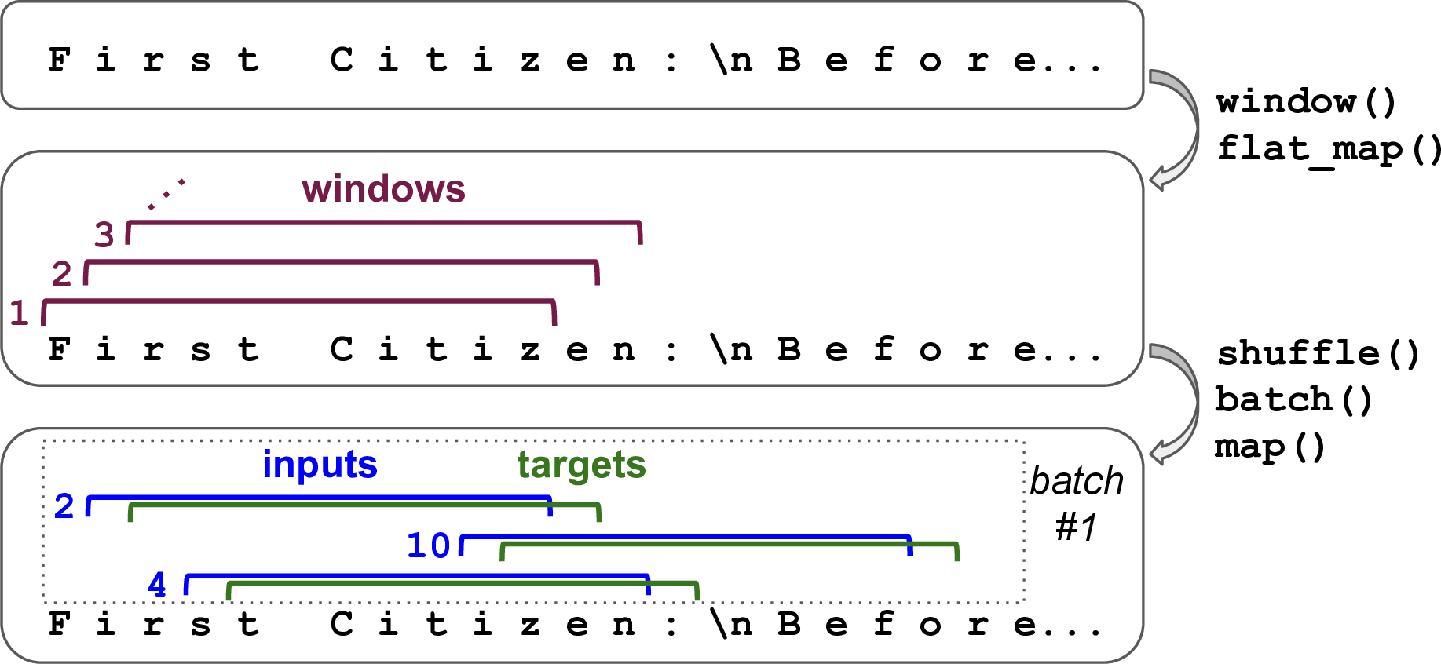

In [ ]:
# one hot
dataset = dataset.map(
    lambda X_batch, Y_batch: (tf.one_hot(X_batch, depth=max_id), Y_batch))

In [ ]:
dataset = dataset.prefetch(1)

In [ ]:
for X_batch, Y_batch in dataset.take(1):
    print(X_batch.shape, Y_batch.shape)

(32, 100, 39) (32, 100)


## Creating and Training the Model

**Warning**: the following code may take up to 24 hours to run, depending on your hardware. If you use a GPU, it may take just 1 or 2 hours, or less.

**Note**: the `GRU` class will only use the GPU (if you have one) when using the default values for the following arguments: `activation`, `recurrent_activation`, `recurrent_dropout`, `unroll`, `use_bias` and `reset_after`. This is why I commented out `recurrent_dropout=0.2` (compared to the book).

In [1]:
model = keras.models.Sequential([
    keras.layers.GRU(128, return_sequences=True, input_shape=[None, max_id],
                     #dropout=0.2, recurrent_dropout=0.2),
                     dropout=0.2),
    keras.layers.GRU(128, return_sequences=True,
                     #dropout=0.2, recurrent_dropout=0.2),
                     dropout=0.2),
    keras.layers.TimeDistributed(keras.layers.Dense(max_id,
                                                    activation="softmax"))
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam")
history = model.fit(dataset, steps_per_epoch=train_size // batch_size,
                    epochs=10)

NameError: ignored

## Using the Model to Generate Text

Now we have a model that can predict the next character in text written by Shakespeare. To feed it some text, we first need to preprocess it like we did earlier, so let’s create a little function for this:

In [ ]:
def preprocess(texts):
    X = np.array(tokenizer.texts_to_sequences(texts)) - 1
    return tf.one_hot(X, max_id)

**Warning**: the `predict_classes()` method is deprecated. Instead, we must use `np.argmax(model(X_new), axis=-1)`.

In [ ]:
X_new = preprocess(["How are yo"])
#Y_pred = model.predict_classes(X_new)
Y_pred = np.argmax(model(X_new), axis=-1)
tokenizer.sequences_to_texts(Y_pred + 1)[0][-1] # 1st sentence, last char

'u'

In [ ]:
tf.random.set_seed(42)

tf.random.categorical([[np.log(0.5), np.log(0.4), np.log(0.1)]], num_samples=40).numpy()

array([[0, 1, 0, 2, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 2, 1, 0, 2, 1,
        0, 1, 2, 1, 1, 1, 2, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 2]])

To generate new text using the Char-RNN model, we could feed it some text, make the model predict the most likely next letter, add it at the end of the text, then give the extended text to the model to guess the next letter, and so on. But in practice this often leads to the same words being repeated over and over again. Instead, we can pick the next character randomly, with a probability equal to the estimated probability, using TensorFlow’s tf.random.categorical() function. This will generate more diverse and interesting text. The categorical() function samples random class indices, given the class log probabilities (logits). To have more control over the diversity of the generated text, we can divide the logits by a number called the temperature, which we can tweak as we wish: a temperature close to 0 will favor the high-probability characters, while a very high temperature will give all characters an equal probability. The following next_char() function uses this approach to pick the next character to add to the input text:

In [ ]:
def next_char(text, temperature=1):
    X_new = preprocess([text])
    y_proba = model(X_new)[0, -1:, :]
    rescaled_logits = tf.math.log(y_proba) / temperature
    char_id = tf.random.categorical(rescaled_logits, num_samples=1) + 1
    return tokenizer.sequences_to_texts(char_id.numpy())[0]

In [ ]:
tf.random.set_seed(42)

next_char("How are yo", temperature=1)

'u'

In [ ]:
def complete_text(text, n_chars=50, temperature=1):
    for _ in range(n_chars):
        text += next_char(text, temperature)
    return text

In [ ]:
tf.random.set_seed(42)

print(complete_text("t", temperature=0.2))

the belly the charges of the other words
and belly 


In [ ]:
print(complete_text("t", temperature=1))

thing! they know't.

biondello:
for you are the own


In [ ]:
print(complete_text("t", temperature=2))

th no cyty
use ffor was firive this toighingaber; b


## Stateful RNN

Until now, we have used only stateless RNNs: at each training iteration the model starts with a hidden state full of zeros, then it updates this state at each time step, and after the last time step, it throws it away, as it is not needed anymore. What if we told the RNN to preserve this final state after processing one training batch and use it as the initial state for the next training batch? This way the model can learn long-term patterns despite only backpropagating through short sequences. This is called a stateful RNN. 

First, note that a stateful RNN only makes sense if each input sequence in a batch starts exactly where the corresponding sequence in the previous batch left off. So the first thing we need to do to build a stateful RNN is to use sequential and nonoverlapping input sequences (rather than the shuffled and overlapping sequences we used to train stateless RNNs).


When creating the Dataset, we must therefore use shift=n_steps (instead of shift=1) when calling the window() method. Moreover, we must obviously not call the shuffle() method. Unfortunately, batching is much harder when preparing a dataset for a stateful RNN than it is for a stateless RNN. Indeed, if we were to call batch(32), then 32 consecutive windows would be put in the same batch, and the following batch would not continue each of these window where it left off. The first batch would contain windows 1 to 32 and the second batch would contain windows 33 to 64, so if you consider, say, the first window of each batch (i.e., windows 1 and 33), you can see that they are not consecutive.


The simplest solution to this problem is to just use “batches” containing a single window:

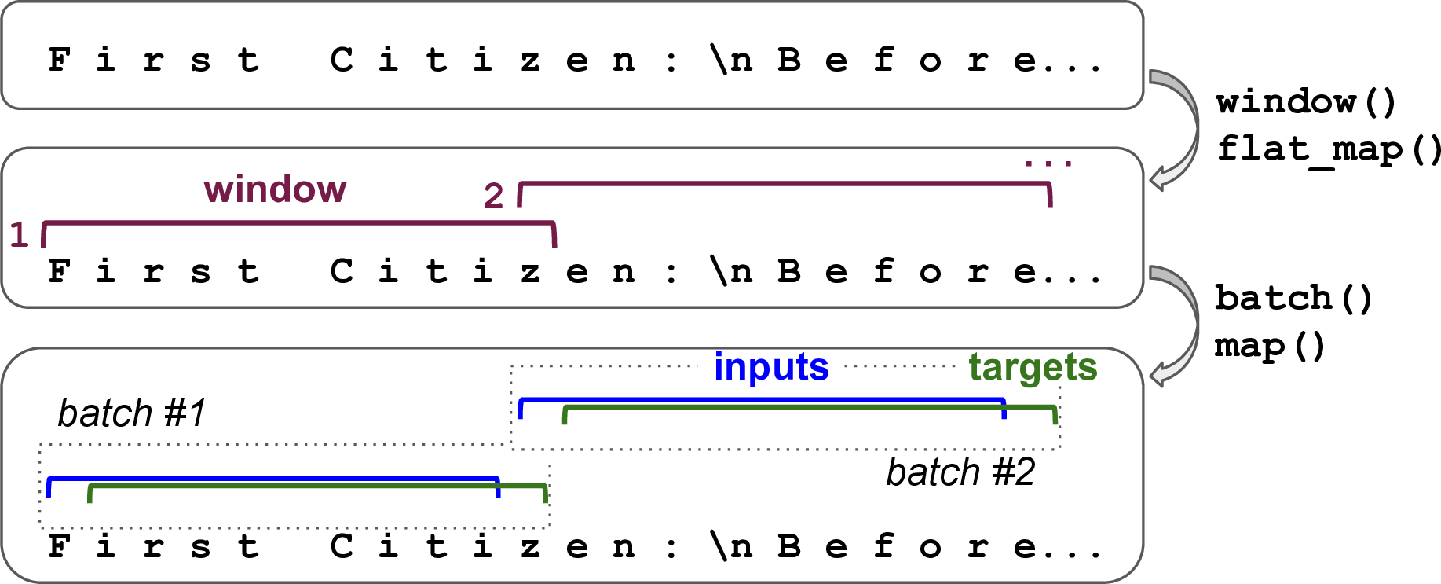

In [ ]:
tf.random.set_seed(42)

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices(encoded[:train_size])
dataset = dataset.window(window_length, shift=n_steps, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(window_length))
dataset = dataset.repeat().batch(1)
dataset = dataset.map(lambda windows: (windows[:, :-1], windows[:, 1:]))
dataset = dataset.map(
    lambda X_batch, Y_batch: (tf.one_hot(X_batch, depth=max_id), Y_batch))
dataset = dataset.prefetch(1)

In [ ]:
batch_size = 32
encoded_parts = np.array_split(encoded[:train_size], batch_size)
datasets = []
for encoded_part in encoded_parts:
    dataset = tf.data.Dataset.from_tensor_slices(encoded_part)
    dataset = dataset.window(window_length, shift=n_steps, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_length))
    datasets.append(dataset)
dataset = tf.data.Dataset.zip(tuple(datasets)).map(lambda *windows: tf.stack(windows))
dataset = dataset.repeat().map(lambda windows: (windows[:, :-1], windows[:, 1:]))
dataset = dataset.map(
    lambda X_batch, Y_batch: (tf.one_hot(X_batch, depth=max_id), Y_batch))
dataset = dataset.prefetch(1)

**Note**: once again, I commented out `recurrent_dropout=0.2` (compared to the book) so you can get GPU acceleration (if you have one).

In [ ]:
model = keras.models.Sequential([
    keras.layers.GRU(128, return_sequences=True, stateful=True,
                     #dropout=0.2, recurrent_dropout=0.2,
                     dropout=0.2,
                     batch_input_shape=[batch_size, None, max_id]),
    keras.layers.GRU(128, return_sequences=True, stateful=True,
                     #dropout=0.2, recurrent_dropout=0.2),
                     dropout=0.2),
    keras.layers.TimeDistributed(keras.layers.Dense(max_id,
                                                    activation="softmax"))
])

In [ ]:
class ResetStatesCallback(keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs):
        self.model.reset_states()

In [ ]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam")
steps_per_epoch = train_size // batch_size // n_steps
history = model.fit(dataset, steps_per_epoch=steps_per_epoch, epochs=50,
                    callbacks=[ResetStatesCallback()])

Train for 313 steps
Epoch 1/50
313/313 [==============================] - 62s 198ms/step - loss: 2.6189
Epoch 2/50
313/313 [==============================] - 58s 187ms/step - loss: 2.2091
Epoch 3/50
313/313 [==============================] - 56s 178ms/step - loss: 2.0775
Epoch 4/50
313/313 [==============================] - 56s 179ms/step - loss: 2.4689
Epoch 5/50
313/313 [==============================] - 56s 179ms/step - loss: 2.3274
Epoch 6/50
313/313 [==============================] - 57s 183ms/step - loss: 2.1412
Epoch 7/50
313/313 [==============================] - 57s 183ms/step - loss: 2.0748
Epoch 8/50
313/313 [==============================] - 56s 179ms/step - loss: 1.9850
Epoch 9/50
313/313 [==============================] - 56s 179ms/step - loss: 1.9465
Epoch 10/50
313/313 [==============================] - 56s 179ms/step - loss: 1.8995
Epoch 11/50
313/313 [==============================] - 57s 182ms/step - loss: 1.8576
Epoch 12/50
313/313 [==============================] -

To use the model with different batch sizes, we need to create a stateless copy. We can get rid of dropout since it is only used during training:

TipAfter this model is trained, it will only be possible to use it to make predictions for batches of the same size as were used during training. To avoid this restriction, create an identical stateless model, and copy the stateful model’s weights to this model.

In [ ]:
stateless_model = keras.models.Sequential([
    keras.layers.GRU(128, return_sequences=True, input_shape=[None, max_id]),
    keras.layers.GRU(128, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(max_id,
                                                    activation="softmax"))
])

To set the weights, we first need to build the model (so the weights get created):

In [ ]:
stateless_model.build(tf.TensorShape([None, None, max_id]))

In [ ]:
stateless_model.set_weights(model.get_weights())
model = stateless_model

In [ ]:
tf.random.set_seed(42)

print(complete_text("t"))

tor:
in the negver up how it thou like him;
when it


# Sentiment Analysis

Now that we have built a character-level model, it’s time to look at word-level models and tackle a common natural language processing task: sentiment analysis. In the process we will learn how to handle sequences of variable lengths using masking.

In [ ]:
tf.random.set_seed(42)

You can load the IMDB dataset easily:

In [ ]:
(X_train, y_train), (X_test, y_test) = keras.datasets.imdb.load_data()

17465344/17464789 [==============================] - 0s 0us/step


In [ ]:
X_train[0][:10]

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65]

Where are the movie reviews? Well, as you can see, the dataset is already preprocessed for you: X_train consists of a list of reviews, each of which is represented as a NumPy array of integers, where each integer represents a word. All punctuation was removed, and then words were converted to lowercase, split by spaces, and finally indexed by frequency (so low integers correspond to frequent words). The integers 0, 1, and 2 are special: they represent the padding token, the start-of-sequence (SSS) token, and unknown words, respectively. If you want to visualize a review, you can decode it like this:



In [ ]:
word_index = keras.datasets.imdb.get_word_index()
id_to_word = {id_ + 3: word for word, id_ in word_index.items()}
for id_, token in enumerate(("<pad>", "<sos>", "<unk>")):
    id_to_word[id_] = token
" ".join([id_to_word[id_] for id_ in X_train[0][:10]])

1646592/1641221 [==============================] - 0s 0us/step


'<sos> this film was just brilliant casting location scenery story'

In [ ]:
import tensorflow_datasets as tfds

datasets, info = tfds.load("imdb_reviews", as_supervised=True, with_info=True)

Shuffling and writing examples to /home/aurelien_geron_kiwisoft_io/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteK5RNB1/imdb_reviews-train.tfrecord


Shuffling and writing examples to /home/aurelien_geron_kiwisoft_io/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteK5RNB1/imdb_reviews-test.tfrecord


Shuffling and writing examples to /home/aurelien_geron_kiwisoft_io/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteK5RNB1/imdb_reviews-unsupervised.tfrecord


Dataset imdb_reviews downloaded and prepared to /home/aurelien_geron_kiwisoft_io/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


In [ ]:
datasets.keys()

dict_keys(['test', 'train', 'unsupervised'])

In [ ]:
train_size = info.splits["train"].num_examples
test_size = info.splits["test"].num_examples

In [ ]:
train_size, test_size

(25000, 25000)

In [ ]:
for X_batch, y_batch in datasets["train"].batch(2).take(1):
    for review, label in zip(X_batch.numpy(), y_batch.numpy()):
        print("Review:", review.decode("utf-8")[:200], "...")
        print("Label:", label, "= Positive" if label else "= Negative")
        print()

Review: This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting  ...
Label: 0 = Negative

Review: I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However  ...
Label: 0 = Negative



In [ ]:
def preprocess(X_batch, y_batch):
    X_batch = tf.strings.substr(X_batch, 0, 300)
    X_batch = tf.strings.regex_replace(X_batch, rb"<br\s*/?>", b" ")
    X_batch = tf.strings.regex_replace(X_batch, b"[^a-zA-Z']", b" ")
    X_batch = tf.strings.split(X_batch)
    return X_batch.to_tensor(default_value=b"<pad>"), y_batch

In [ ]:
preprocess(X_batch, y_batch)

(<tf.Tensor: shape=(2, 53), dtype=string, numpy=
 array([[b'This', b'was', b'an', b'absolutely', b'terrible', b'movie',
         b"Don't", b'be', b'lured', b'in', b'by', b'Christopher',
         b'Walken', b'or', b'Michael', b'Ironside', b'Both', b'are',
         b'great', b'actors', b'but', b'this', b'must', b'simply', b'be',
         b'their', b'worst', b'role', b'in', b'history', b'Even',
         b'their', b'great', b'acting', b'could', b'not', b'redeem',
         b'this', b"movie's", b'ridiculous', b'storyline', b'This',
         b'movie', b'is', b'an', b'early', b'nineties', b'US',
         b'propaganda', b'pi', b'<pad>', b'<pad>', b'<pad>'],
        [b'I', b'have', b'been', b'known', b'to', b'fall', b'asleep',
         b'during', b'films', b'but', b'this', b'is', b'usually', b'due',
         b'to', b'a', b'combination', b'of', b'things', b'including',
         b'really', b'tired', b'being', b'warm', b'and', b'comfortable',
         b'on', b'the', b'sette', b'and', b'having', b'j

Next, we need to construct the vocabulary. This requires going through the whole training set once, applying our preprocess() function, and using a Counter to count the number of occurrences of each word:

In [ ]:
from collections import Counter

vocabulary = Counter()
for X_batch, y_batch in datasets["train"].batch(32).map(preprocess):
    for review in X_batch:
        vocabulary.update(list(review.numpy()))

In [ ]:
vocabulary.most_common()[:3]

[(b'<pad>', 214309), (b'the', 61137), (b'a', 38564)]

In [ ]:
len(vocabulary)

53893

so let’s truncate the vocabulary, keeping only the 10,000 most common words:

In [ ]:
vocab_size = 10000
truncated_vocabulary = [
    word for word, count in vocabulary.most_common()[:vocab_size]]

Now we need to add a preprocessing step to replace each word with its ID (i.e., its index in the vocabulary). Just like we did in Chapter 13, we will create a lookup table for this, using 1,000 out-of-vocabulary (oov) buckets:

In [ ]:
word_to_id = {word: index for index, word in enumerate(truncated_vocabulary)}
for word in b"This movie was faaaaaantastic".split():
    print(word_to_id.get(word) or vocab_size)

22
12
11
10000


In [ ]:
words = tf.constant(truncated_vocabulary)
word_ids = tf.range(len(truncated_vocabulary), dtype=tf.int64)
vocab_init = tf.lookup.KeyValueTensorInitializer(words, word_ids)
num_oov_buckets = 1000
table = tf.lookup.StaticVocabularyTable(vocab_init, num_oov_buckets)

In [ ]:
table.lookup(tf.constant([b"This movie was faaaaaantastic".split()]))

<tf.Tensor: shape=(1, 4), dtype=int64, numpy=array([[   22,    12,    11, 10053]])>

In [ ]:
def encode_words(X_batch, y_batch):
    return table.lookup(X_batch), y_batch

train_set = datasets["train"].repeat().batch(32).map(preprocess)
train_set = train_set.map(encode_words).prefetch(1)

In [ ]:
for X_batch, y_batch in train_set.take(1):
    print(X_batch)
    print(y_batch)

tf.Tensor(
[[  22   11   28 ...    0    0    0]
 [   6   21   70 ...    0    0    0]
 [4099 6881    1 ...    0    0    0]
 ...
 [  22   12  118 ...  331 1047    0]
 [1757 4101  451 ...    0    0    0]
 [3365 4392    6 ...    0    0    0]], shape=(32, 60), dtype=int64)
tf.Tensor([0 0 0 1 1 1 0 0 0 0 0 1 1 0 1 0 1 1 1 0 1 1 1 1 1 0 0 0 1 0 0 0], shape=(32,), dtype=int64)


The first layer is an Embedding layer, which will convert word IDs into embeddings (introduced in Chapter 13). The embedding matrix needs to have one row per word ID (vocab_size + num_oov_buckets) and one column per embedding dimension (this example uses 128 dimensions, but this is a hyperparameter you could tune). Whereas the inputs of the model will be 2D tensors of shape [batch size, time steps], the output of the Embedding layer will be a 3D tensor of shape [batch size, time steps, embedding size].

In [ ]:
embed_size = 128
model = keras.models.Sequential([
    keras.layers.Embedding(vocab_size + num_oov_buckets, embed_size,
                           mask_zero=True, # not shown in the book
                           input_shape=[None]),
    keras.layers.GRU(128, return_sequences=True),
    keras.layers.GRU(128),
    keras.layers.Dense(1, activation="sigmoid")
])
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
history = model.fit(train_set, steps_per_epoch=train_size // 32, epochs=5)

Train for 781 steps
Epoch 1/5
781/781 [==============================] - 118s 152ms/step - loss: 0.5305 - accuracy: 0.7282
Epoch 2/5
781/781 [==============================] - 113s 145ms/step - loss: 0.3459 - accuracy: 0.8554
Epoch 3/5
781/781 [==============================] - 113s 145ms/step - loss: 0.1913 - accuracy: 0.9319
Epoch 4/5
781/781 [==============================] - 114s 146ms/step - loss: 0.1341 - accuracy: 0.9535
Epoch 5/5
781/781 [==============================] - 116s 148ms/step - loss: 0.1011 - accuracy: 0.9624


Or using manual masking:

As it stands, the model will need to learn that the padding tokens should be ignored. But we already know that! Why don’t we tell the model to ignore the padding tokens, so that it can focus on the data that actually matters? It’s actually trivial: simply add mask_zero=True when creating the Embedding layer. This means that padding tokens (whose ID is 0)8 will be ignored by all downstream layers. That’s all!

Using masking layers and automatic mask propagation works best for simple Sequential models. It will not always work for more complex models, such as when you need to mix Conv1D layers with recurrent layers. In such cases, you will need to explicitly compute the mask and pass it to the appropriate layers, using either the Functional API or the Subclassing API. For example, the following model is identical to the previous model, except it is built using the Functional API and handles masking manually:

In [ ]:
K = keras.backend
embed_size = 128
inputs = keras.layers.Input(shape=[None])
mask = keras.layers.Lambda(lambda inputs: K.not_equal(inputs, 0))(inputs)
z = keras.layers.Embedding(vocab_size + num_oov_buckets, embed_size)(inputs)
z = keras.layers.GRU(128, return_sequences=True)(z, mask=mask)
z = keras.layers.GRU(128)(z, mask=mask)
outputs = keras.layers.Dense(1, activation="sigmoid")(z)
model = keras.models.Model(inputs=[inputs], outputs=[outputs])
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
history = model.fit(train_set, steps_per_epoch=train_size // 32, epochs=5)

Train for 781 steps
Epoch 1/5
781/781 [==============================] - 118s 152ms/step - loss: 0.5425 - accuracy: 0.7155
Epoch 2/5
781/781 [==============================] - 112s 143ms/step - loss: 0.3479 - accuracy: 0.8558
Epoch 3/5
781/781 [==============================] - 112s 144ms/step - loss: 0.1761 - accuracy: 0.9388
Epoch 4/5
781/781 [==============================] - 115s 147ms/step - loss: 0.1281 - accuracy: 0.9531
Epoch 5/5
781/781 [==============================] - 116s 148ms/step - loss: 0.1088 - accuracy: 0.9603


## Reusing Pretrained Embeddings

The TensorFlow Hub project makes it easy to reuse pretrained model components in your own models. These model components are called modules. Simply browse the TF Hub repository, find the one you need, and copy the code example into your project, and the module will be automatically downloaded, along with its pretrained weights, and included in your model. Easy!

In [ ]:
tf.random.set_seed(42)

In [ ]:
TFHUB_CACHE_DIR = os.path.join(os.curdir, "my_tfhub_cache")
os.environ["TFHUB_CACHE_DIR"] = TFHUB_CACHE_DIR

In [ ]:
import tensorflow_hub as hub

model = keras.Sequential([
    hub.KerasLayer("https://tfhub.dev/google/tf2-preview/nnlm-en-dim50/1",
                   dtype=tf.string, input_shape=[], output_shape=[50]),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dense(1, activation="sigmoid")
])
model.compile(loss="binary_crossentropy", optimizer="adam",
              metrics=["accuracy"])

The hub.KerasLayer layer downloads the module from the given URL. This particular module is a sentence encoder: it takes strings as input and encodes each one as a single vector (in this case, a 50-dimensional vector). Internally, it parses the string (splitting words on spaces) and embeds each word using an embedding matrix that was pretrained on a huge corpus: the Google News 7B corpus (seven billion words long!). Then it computes the mean of all the word embeddings, and the result is the sentence embedding.9 We can then add two simple Dense layers to create a good sentiment analysis model. By default, a hub.KerasLayer is not trainable, but you can set trainable=True when creating it to change that so that you can fine-tune it for your task.

WARNING
Not all TF Hub modules support TensorFlow 2, so make sure you choose a module that does.

In [ ]:
for dirpath, dirnames, filenames in os.walk(TFHUB_CACHE_DIR):
    for filename in filenames:
        print(os.path.join(dirpath, filename))

./my_tfhub_cache/82c4aaf4250ffb09088bd48368ee7fd00e5464fe.descriptor.txt
./my_tfhub_cache/82c4aaf4250ffb09088bd48368ee7fd00e5464fe/saved_model.pb
./my_tfhub_cache/82c4aaf4250ffb09088bd48368ee7fd00e5464fe/variables/variables.data-00000-of-00001
./my_tfhub_cache/82c4aaf4250ffb09088bd48368ee7fd00e5464fe/variables/variables.index
./my_tfhub_cache/82c4aaf4250ffb09088bd48368ee7fd00e5464fe/assets/tokens.txt


Next, we can just load the IMDb reviews dataset—no need to preprocess it (except for batching and prefetching)—and directly train the model:

In [ ]:
import tensorflow_datasets as tfds

datasets, info = tfds.load("imdb_reviews", as_supervised=True, with_info=True)
train_size = info.splits["train"].num_examples
batch_size = 32
train_set = datasets["train"].repeat().batch(batch_size).prefetch(1)
history = model.fit(train_set, steps_per_epoch=train_size // batch_size, epochs=5)

Train for 781 steps
Epoch 1/5
781/781 [==============================] - 128s 164ms/step - loss: 0.5460 - accuracy: 0.7267
Epoch 2/5
781/781 [==============================] - 128s 164ms/step - loss: 0.5129 - accuracy: 0.7495
Epoch 3/5
781/781 [==============================] - 129s 165ms/step - loss: 0.5082 - accuracy: 0.7530
Epoch 4/5
781/781 [==============================] - 128s 164ms/step - loss: 0.5047 - accuracy: 0.7533
Epoch 5/5
781/781 [==============================] - 128s 164ms/step - loss: 0.5015 - accuracy: 0.7560


So far, we have looked at time series, text generation using Char-RNN, and sentiment analysis using word-level RNN models, training our own word embeddings or reusing pretrained embeddings. Let’s now look at another important NLP task: neural machine translation (NMT), first using a pure Encoder–Decoder model, then improving it with attention mechanisms, and finally looking the extraordinary Transformer architecture.

## Automatic Translation

In short, the English sentences are fed to the encoder, and the decoder outputs the French translations. Note that the French translations are also used as inputs to the decoder, but shifted back by one step. In other words, the decoder is given as input the word that it should have output at the previous step (regardless of what it actually output). For the very first word, it is given the start-of-sequence (SOS) token. The decoder is expected to end the sentence with an end-of-sequence (EOS) token.


Note that the English sentences are reversed before they are fed to the encoder. For example, “I drink milk” is reversed to “milk drink I.” This ensures that the beginning of the English sentence will be fed last to the encoder, which is useful because that’s generally the first thing that the decoder needs to translate.

Each word is initially represented by its ID (e.g., 288 for the word “milk”). Next, an embedding layer returns the word embedding. These word embeddings are what is actually fed to the encoder and the decoder.

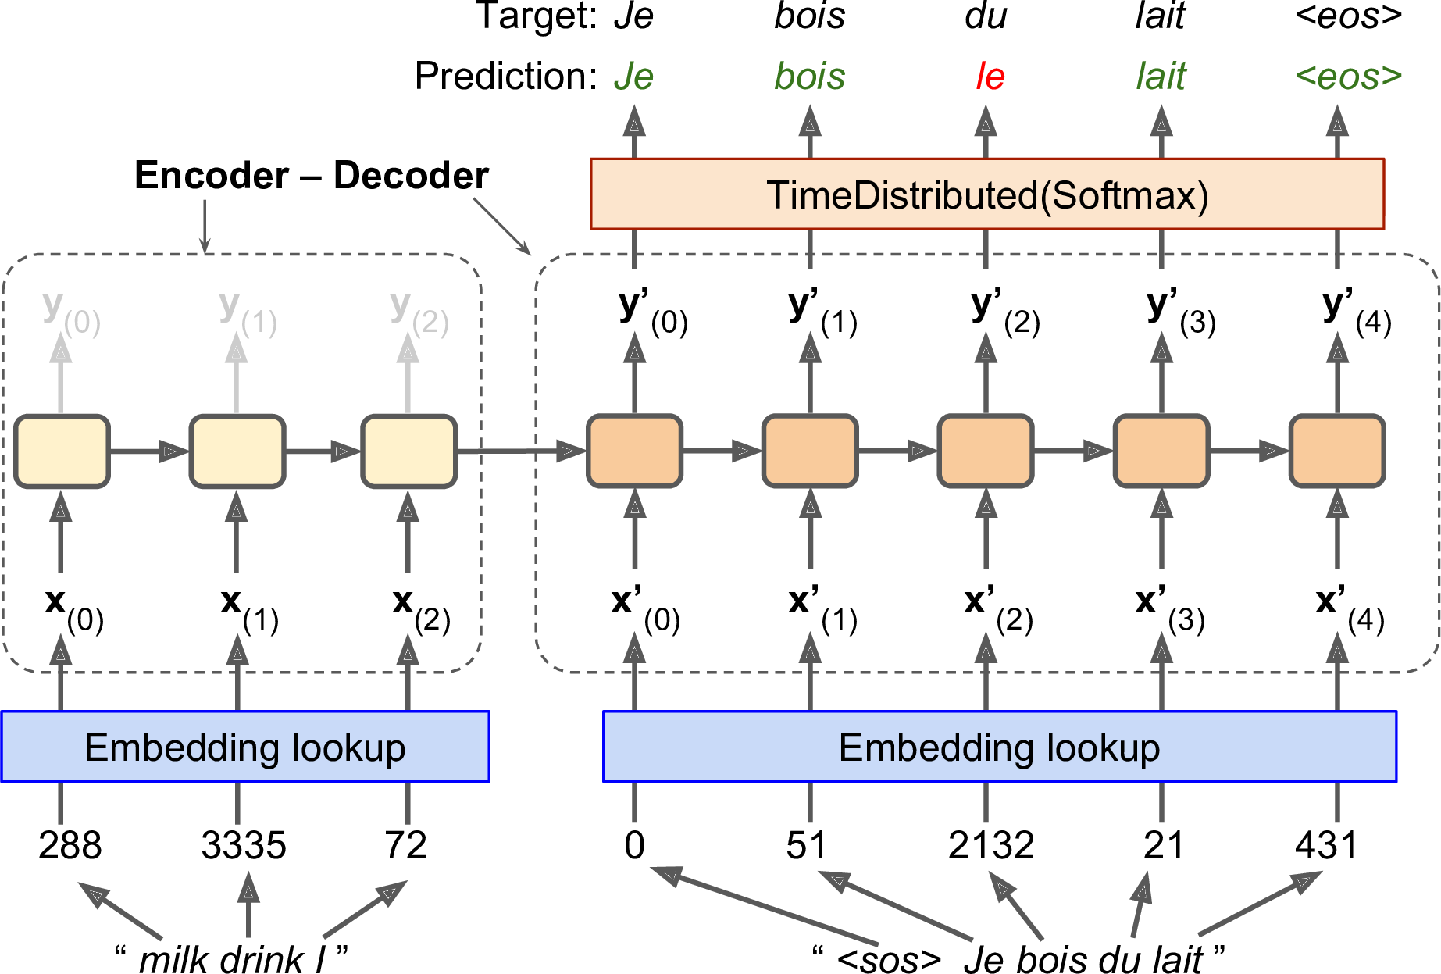

At each step, the decoder outputs a score for each word in the output vocabulary (i.e., French), and then the softmax layer turns these scores into probabilities. For example, at the first step the word “Je” may have a probability of 20%, “Tu” may have a probability of 1%, and so on. The word with the highest probability is output. This is very much like a regular classification task, so you can train the model using the "sparse_categorical_crossentropy" loss, much like we did in the Char-RNN model.


Note that at inference time (after training), you will not have the target sentence to feed to the decoder. Instead, simply feed the decoder the word that it output at the previous step,
this will require an embedding lookup that is not shown in the diagram

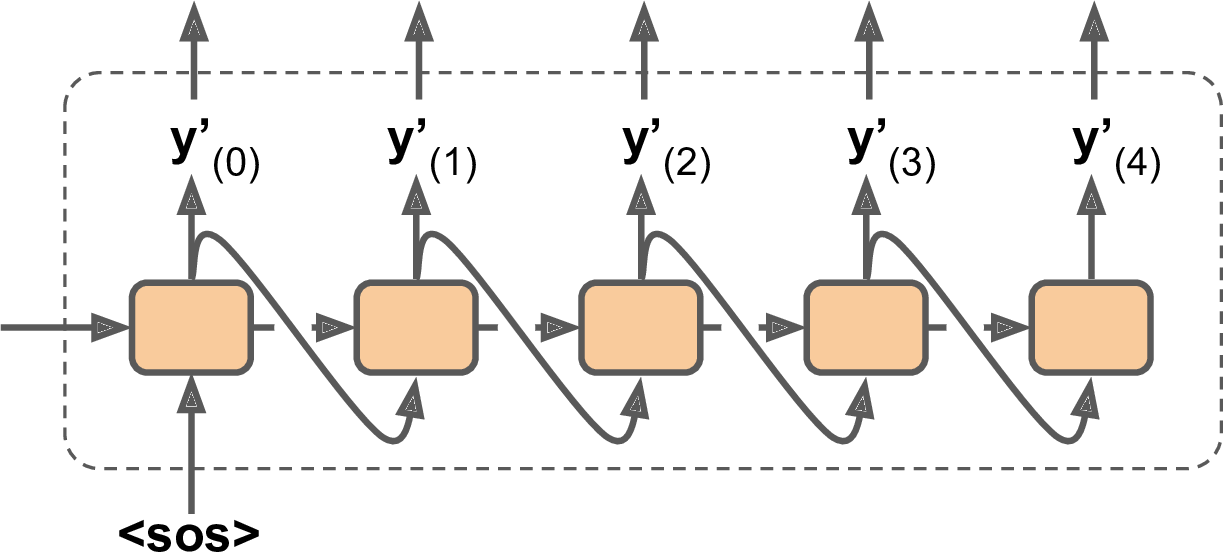

- So far we have assumed that all input sequences (to the encoder and to the decoder) have a constant length. But obviously sentence lengths vary. Since regular tensors have fixed shapes, they can only contain sentences of the same length. You can use masking to handle this, as discussed earlier. However, if the sentences have very different lengths, you can’t just crop them like we did for sentiment analysis (because we want full translations, not cropped translations). Instead, group sentences into buckets of similar lengths (e.g., a bucket for the 1- to 6-word sentences, another for the 7- to 12-word sentences, and so on), using padding for the shorter sequences to ensure all sentences in a bucket have the same length (check out the tf.data.experimental.bucket_by_sequence_length()
function for this). For example, “I drink milk” becomes “<pad> <pad> <pad> milk drink I.”

- We want to ignore any output past the EOS token, so these tokens should not contribute to the loss (they must be masked out). For example, if the model outputs “Je bois du lait <eos> oui,” the loss for the last word should be ignored.

- When the output vocabulary is large (which is the case here), outputting a probability for each and every possible word would be terribly slow. If the target vocabulary contains, say, 50,000 French words, then the decoder would output 50,000-dimensional vectors, and then computing the softmax function over such a large vector would be very computationally intensive. To avoid this, one solution is to look only at the logits output by the model for the correct word and for a random sample of incorrect words, then compute an approximation of the loss based only on these logits. This sampled softmax technique was introduced in 2015 by Sébastien Jean et al..11 In TensorFlow you can use the tf.nn.sampled_softmax_loss() function for this during training and use the normal softmax function at inference time
(sampled softmax cannot be used at inference time because it requires knowing the target).

In [ ]:
tf.random.set_seed(42)

In [ ]:
vocab_size = 100
embed_size = 10

The TensorFlow Addons project includes many sequence-to-sequence tools to let you easily build production-ready Encoder–Decoders. For example, the following code creates a basic Encoder–Decoder model,

In [ ]:
import tensorflow_addons as tfa

encoder_inputs = keras.layers.Input(shape=[None], dtype=np.int32)
decoder_inputs = keras.layers.Input(shape=[None], dtype=np.int32)
sequence_lengths = keras.layers.Input(shape=[], dtype=np.int32)

embeddings = keras.layers.Embedding(vocab_size, embed_size)
encoder_embeddings = embeddings(encoder_inputs)
decoder_embeddings = embeddings(decoder_inputs)

encoder = keras.layers.LSTM(512, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_embeddings)
encoder_state = [state_h, state_c]

sampler = tfa.seq2seq.sampler.TrainingSampler()

decoder_cell = keras.layers.LSTMCell(512)
output_layer = keras.layers.Dense(vocab_size)
decoder = tfa.seq2seq.basic_decoder.BasicDecoder(decoder_cell, sampler,
                                                 output_layer=output_layer)
final_outputs, final_state, final_sequence_lengths = decoder(
    decoder_embeddings, initial_state=encoder_state,
    sequence_length=sequence_lengths)
Y_proba = tf.nn.softmax(final_outputs.rnn_output)

model = keras.models.Model(
    inputs=[encoder_inputs, decoder_inputs, sequence_lengths],
    outputs=[Y_proba])

The code is mostly self-explanatory, but there are a few points to note. First, we set return_state=True when creating the LSTM layer so that we can get its final hidden state and pass it to the decoder. Since we are using an LSTM cell, it actually returns two hidden states (short term and long term). The TrainingSampler is one of several samplers available in TensorFlow Addons: their role is to tell the decoder at each step what it should pretend the previous output was. During inference, this should be the embedding of the token that was actually output. During training, it should be the embedding of the previous target token: this is why we used the TrainingSampler. In practice, it is often a good idea to start training with the embedding of the target of the previous time step and gradually transition to using the embedding of the actual token that was output at the previous step. This idea was introduced in a 2015 paper12 by Samy Bengio et al. The ScheduledEmbeddingTrainingSampler
will randomly choose between the target or the actual output, with a probability that you can gradually change during training.

In [ ]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam")

In [ ]:
X = np.random.randint(100, size=10*1000).reshape(1000, 10)
Y = np.random.randint(100, size=15*1000).reshape(1000, 15)
X_decoder = np.c_[np.zeros((1000, 1)), Y[:, :-1]]
seq_lengths = np.full([1000], 15)

history = model.fit([X, X_decoder, seq_lengths], Y, epochs=2)

Train on 1000 samples
Epoch 1/2
1000/1000 [==============================] - 6s 6ms/sample - loss: 4.6053
Epoch 2/2
1000/1000 [==============================] - 3s 3ms/sample - loss: 4.6031


### Bidirectional Recurrent Layers

A each time step, a regular recurrent layer only looks at past and present inputs before generating its output. In other words, it is “causal,” meaning it cannot look into the future. This type of RNN makes sense when forecasting time series, but for many NLP tasks, such as Neural Machine Translation, it is often preferable to look ahead at the next words before encoding a given word. For example, consider the phrases “the Queen of the United Kingdom,” “the queen of hearts,” and “the queen bee”: to properly encode the word “queen,” you need to look ahead. To implement this, run two recurrent layers on the same inputs, one reading the words from left to right and the other reading them from right to left. Then simply combine their outputs at each time step, typically by concatenating them. This is called a bidirectional recurrent layer 

The Bidirectional layer will create a clone of the GRU layer (but in the reverse direction), and it will run both and concatenate their outputs. So although the GRU layer has 10 units, the Bidirectional layer will output 20 values per time step.

In [ ]:
model = keras.models.Sequential([
    keras.layers.GRU(10, return_sequences=True, input_shape=[None, 10]),
    keras.layers.Bidirectional(keras.layers.GRU(10, return_sequences=True))
])

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_10 (GRU)                 (None, None, 10)          660       
_________________________________________________________________
bidirectional (Bidirectional (None, None, 20)          1320      
Total params: 1,980
Trainable params: 1,980
Non-trainable params: 0
_________________________________________________________________


## Beam Search

Suppose you train an Encoder–Decoder model, and use it to translate the French sentence “Comment vas-tu?” to English. You are hoping that it will output the proper translation (“How are you?”), but unfortunately it outputs “How will you?” Looking at the training set, you notice many sentences such as “Comment vas-tu jouer?” which translates to “How will you play?” So it wasn’t absurd for the model to output “How will” after seeing “Comment vas.” Unfortunately, in this case it was a mistake, and the model could not go back and fix it, so it tried to complete the sentence as best it could. By greedily outputting the most likely word at every step, it ended up with a suboptimal translation. How can we give the model a chance to go back and fix mistakes it made earlier? One of the most common solutions is beam search: it keeps track of a short list of the k most promising sentences (say, the top three), and at each decoder step it tries to extend them by one word, keeping only the k most likely sentences. The parameter k is called the beam width.

For example, suppose you use the model to translate the sentence “Comment vas-tu?” using beam search with a beam width of 3. At the first decoder step, the model will output an estimated probability for each possible word. Suppose the top three words are “How” (75% estimated probability), “What” (3%), and “You” (1%). That’s our short list so far. Next, we create three copies of our model and use them to find the next word for each sentence. Each model will output one estimated probability per word in the vocabulary. The first model will try to find the next word in the sentence “How,” and perhaps it will output a probability of 36% for the word “will,” 32% for the word “are,” 16% for the word “do,” and so on. Note that these are actually conditional probabilities, given that the sentence starts with “How.” The second model will try to complete the sentence “What”; it might output a conditional probability of 50% for the word “are,” and so on. Assuming the vocabulary has 10,000 words, each model will output 10,000 probabilities.

Next, we compute the probabilities of each of the 30,000 two-word sentences that these models considered (3 × 10,000). We do this by multiplying the estimated conditional probability of each word by the estimated probability of the sentence it completes. For example, the estimated probability of the sentence “How” was 75%, while the estimated conditional probability of the word “will” (given that the first word is “How”) was 36%, so the estimated probability of the sentence “How will” is 75% × 36% = 27%. After computing the probabilities of all 30,000 two-word sentences, we keep only the top 3. Perhaps they all start with the word “How”: “How will” (27%), “How are” (24%), and “How do” (12%). Right now, the sentence “How will” is winning, but “How are” has not been eliminated.


Then we repeat the same process: we use three models to predict the next word in each of these three sentences, and we compute the probabilities of all 30,000 three-word sentences we considered. Perhaps the top three are now “How are you” (10%), “How do you” (8%), and “How will you” (2%). At the next step we may get “How do you do” (7%), “How are you <eos>” (6%), and “How are you doing” (3%). Notice that “How will” was eliminated, and we now have three perfectly reasonable translations. We boosted our Encoder–Decoder model’s performance without any extra training, simply by using it more wisely.


You can implement beam search fairly easily using TensorFlow Addons:

In [2]:
beam_width = 10
decoder = tfa.seq2seq.beam_search_decoder.BeamSearchDecoder(    cell=decoder_cell, beam_width=beam_width, output_layer=output_layer)
decoder_initial_state = tfa.seq2seq.beam_search_decoder.tile_batch(    
    encoder_state, multiplier=beam_width)
final_outputs, _, _ = decoder(    
    embedding_decoder, start_tokens=start_tokens, end_token=end_token,    
    initial_state=decoder_initial_state)

NameError: ignored

We first create a BeamSearchDecoder, which wraps all the decoder clones (in this case 10 clones). Then we create one copy of the encoder’s final state for each decoder clone, and we pass these states to the decoder, along with the start and end tokens.

With all this, you can get good translations for fairly short sentences (especially if you use pretrained word embeddings). Unfortunately, this model will be really bad at translating long sentences. 

Once again, the problem comes from the limited short-term memory of RNNs. Attention mechanisms are the game-changing innovation that addressed this problem.


## Attention Mechanism

Consider the path from the word “milk” to its translation “lait” in Figure 16-3: it is quite long! This means that a representation of this word (along with all the other words) needs to be carried over many steps before it is actually used. Can’t we make this path shorter?

This was the core idea in a groundbreaking 2014 paper13 by Dzmitry Bahdanau et al. They introduced a technique that allowed the decoder to focus on the appropriate words (as encoded by the encoder) at each time step. For example, at the time step where the decoder needs to output the word “lait,” it will focus its attention on the word “milk.” This means that the path from an input word to its translation is now much shorter, so the short-term memory limitations of RNNs have much less impact. Attention mechanisms revolutionized neural machine translation (and NLP in general), allowing a significant improvement in the state of the art, especially for long sentences (over 30 words).

On the left, you have the encoder and the decoder. Instead of just sending the encoder’s final hidden state to the decoder (which is still done, although it is not shown in the figure), we now send all of its outputs to the decoder. At each time step, the decoder’s memory cell computes a weighted sum of all these encoder outputs: this determines which words it will focus on at this step. The weight α(t,i) is the weight of the ith encoder output at the tth decoder time step. For example, if the weight α(3,2) is much larger than the weights α(3,0) and α(3,1), then the decoder will pay much more attention to word number 2 (“milk”) than to the other two words, at least at this time step. The rest of the decoder works just like earlier: at each time step the memory cell receives the inputs we just discussed, plus the hidden state from the previous time step, and finally (although it is not represented in the diagram) it receives the target word from the previous time step (or at inference time, the output from the previous time step).

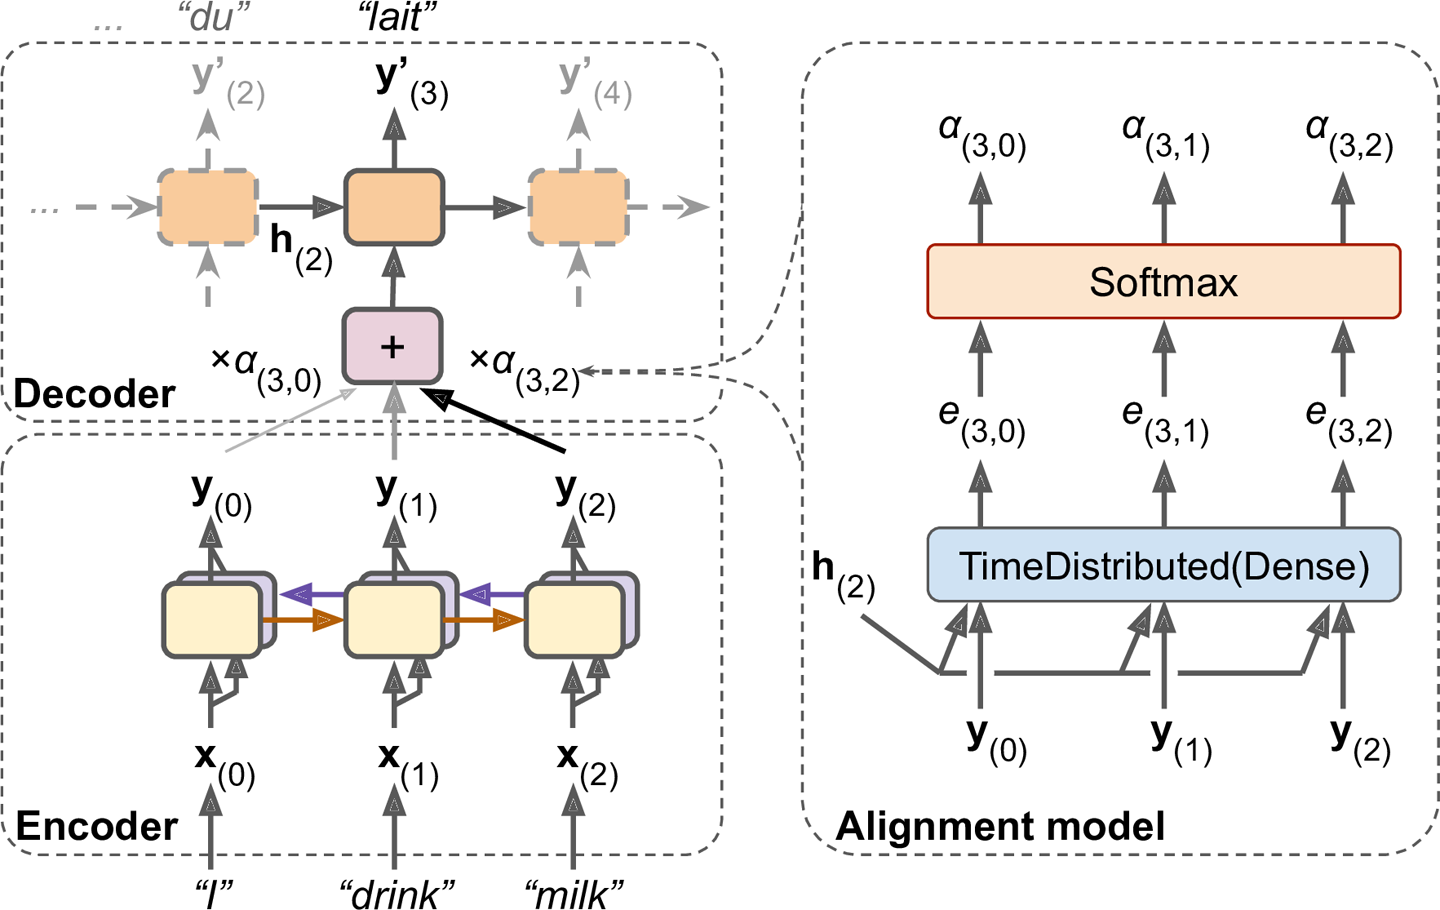




But where do these α(t,i) weights come from? It’s actually pretty simple: they are generated by a type of small neural network called an alignment model (or an attention layer), which is trained jointly with the rest of the Encoder–Decoder model. This alignment model is illustrated on the righthand side of Figure 16-6. It starts with a time-distributed Dense layer15 with a single neuron, which receives as input all the encoder outputs, concatenated with the decoder’s previous hidden state (e.g., h(2)). This layer outputs a score (or energy) for each encoder output (e.g., e(3, 2)): this score measures how well each output is aligned with the decoder’s previous hidden state. Finally, all the scores go through a softmax layer to get a final weight for each encoder output (e.g., α(3,2)). All the weights for a given decoder time step add up to 1 (since the softmax layer is not time-distributed). This particular attention mechanism is called Bahdanau attention (named after the paper’s first author). Since it concatenates the encoder output with the decoder’s previous hidden state, it is sometimes called concatenative attention (or additive attention).

NoteIf the input sentence is n words long, and assuming the output sentence is about as long, then this model will need to compute about n2 weights. Fortunately, this quadratic computational complexity is still tractable because even long sentences don’t have thousands of words.

Another common attention mechanism was proposed shortly after, in a 2015 paper16 by Minh-Thang Luong et al. Because the goal of the attention mechanism is to measure the similarity between one of the encoder’s outputs and the decoder’s previous hidden state, the authors proposed to simply compute the dot product (see Chapter 4) of these two vectors, as this is often a fairly good similarity measure, and modern hardware can compute it much faster. For this to be possible, both vectors must have the same dimensionality. This is called Luong attention (again, after the paper’s first author), or sometimes multiplicative attention. The dot product gives a score, and all the scores (at a given decoder time step) go through a softmax layer to give the final weights, just like in Bahdanau attention. Another simplification they proposed was to use the decoder’s hidden state at the current time step rather than at the previous time step (i.e., h(t) rather than h(t–1)), then to use the output of the attention mechanism (noted h˜(t)h~(t)<math xmlns="http://www.w3.org/1998/Math/MathML"><msub><mover><mi mathvariant="bold">h</mi><mo>~</mo></mover><mrow><mo>(</mo><mi>t</mi><mo>)</mo></mrow></msub></math>) 

directly to compute the decoder’s predictions (rather than using it to compute the decoder’s current hidden state). They also proposed a variant of the dot product mechanism where the encoder outputs first go through a linear transformation (i.e., a time-distributed Dense layer without a bias term) before the dot products are computed. This is called the “general” dot product approach. They compared both dot product approaches to the concatenative attention mechanism (adding a rescaling parameter vector v), and they observed that the dot product variants performed better than concatenative attention. For this reason, concatenative attention is much less used now. The equations for these three attention mechanisms are summarized


h˜(t)=∑iα(t,i)y(i)

with α(t,i)=exp(e(t,i)) \ ∑i'exp(e(t,i'))


and e(t,i)=⎧⎩⎨⎪⎪⎪⎪h(t)⊺ y(i)h(t)⊺ W y(i)v⊺tanh(W[h(t);y(i)])dot general concat

In [ ]:
attention_mechanism = tfa.seq2seq.attention_wrapper.LuongAttention(  
      n_units, encoder_outputs, memory_sequence_length=encoder_sequence_length)
attention_decoder_cell = tfa.seq2seq.attention_wrapper.AttentionWrapper(  
      decoder_cell, attention_mechanism, attention_layer_size=n_units)

We simply wrap the decoder cell in an AttentionWrapper, and we provide the desired attention mechanism (Luong attention in this example).

## Visual Attention

Attention mechanisms are now used for a variety of purposes. One of their first applications beyond NMT was in generating image captions using visual attention:17 a convolutional neural network first processes the image and outputs some feature maps, then a decoder RNN equipped with an attention mechanism generates the caption, one word at a time. At each decoder time step (each word), the decoder uses the attention model to focus on just the right part of the image. For example, in Figure 16-7, the model generated the caption “A woman is throwing a frisbee in a park,” and you can see what part of the input image the decoder focused its attention on when it was about to output the word “frisbee”: clearly, most of its attention was focused on the frisbee.


Explainability

One extra benefit of attention mechanisms is that they make it easier to understand what led the model to produce its output. This is called explainability. It can be especially useful when the model makes a mistake: for example, if an image of a dog walking in the snow is labeled as “a wolf walking in the snow,” then you can go back and check what the model focused on when it output the word “wolf.” You may find that it was paying attention not only to the dog, but also to the snow, hinting at a possible explanation: perhaps the way the model learned to distinguish dogs from wolves is by checking whether or not there’s a lot of snow around. You can then fix this by training the model with more images of wolves without snow, and dogs with snow. This example comes from a great 2016 paper19 by Marco Tulio Ribeiro et al. that uses a different approach to explainability: learning an interpretable model locally around a classifier’s prediction.

In some applications, explainability is not just a tool to debug a model; it can be a legal requirement (think of a system deciding whether or not it should grant you a loan).

## Attention Is All You Need: The Transformer Architecture

In a groundbreaking 2017 paper,20 a team of Google researchers suggested that “Attention Is All You Need.” They managed to create an architecture called the Transformer, which significantly improved the state of the art in NMT without using any recurrent or convolutional layers,21 just attention mechanisms (plus embedding layers, dense layers, normalization layers, and a few other bits and pieces). As an extra bonus, this architecture was also much faster to train and easier to parallelize, so they managed to train it at a fraction of the time and cost of the previous state-of-the-art models.

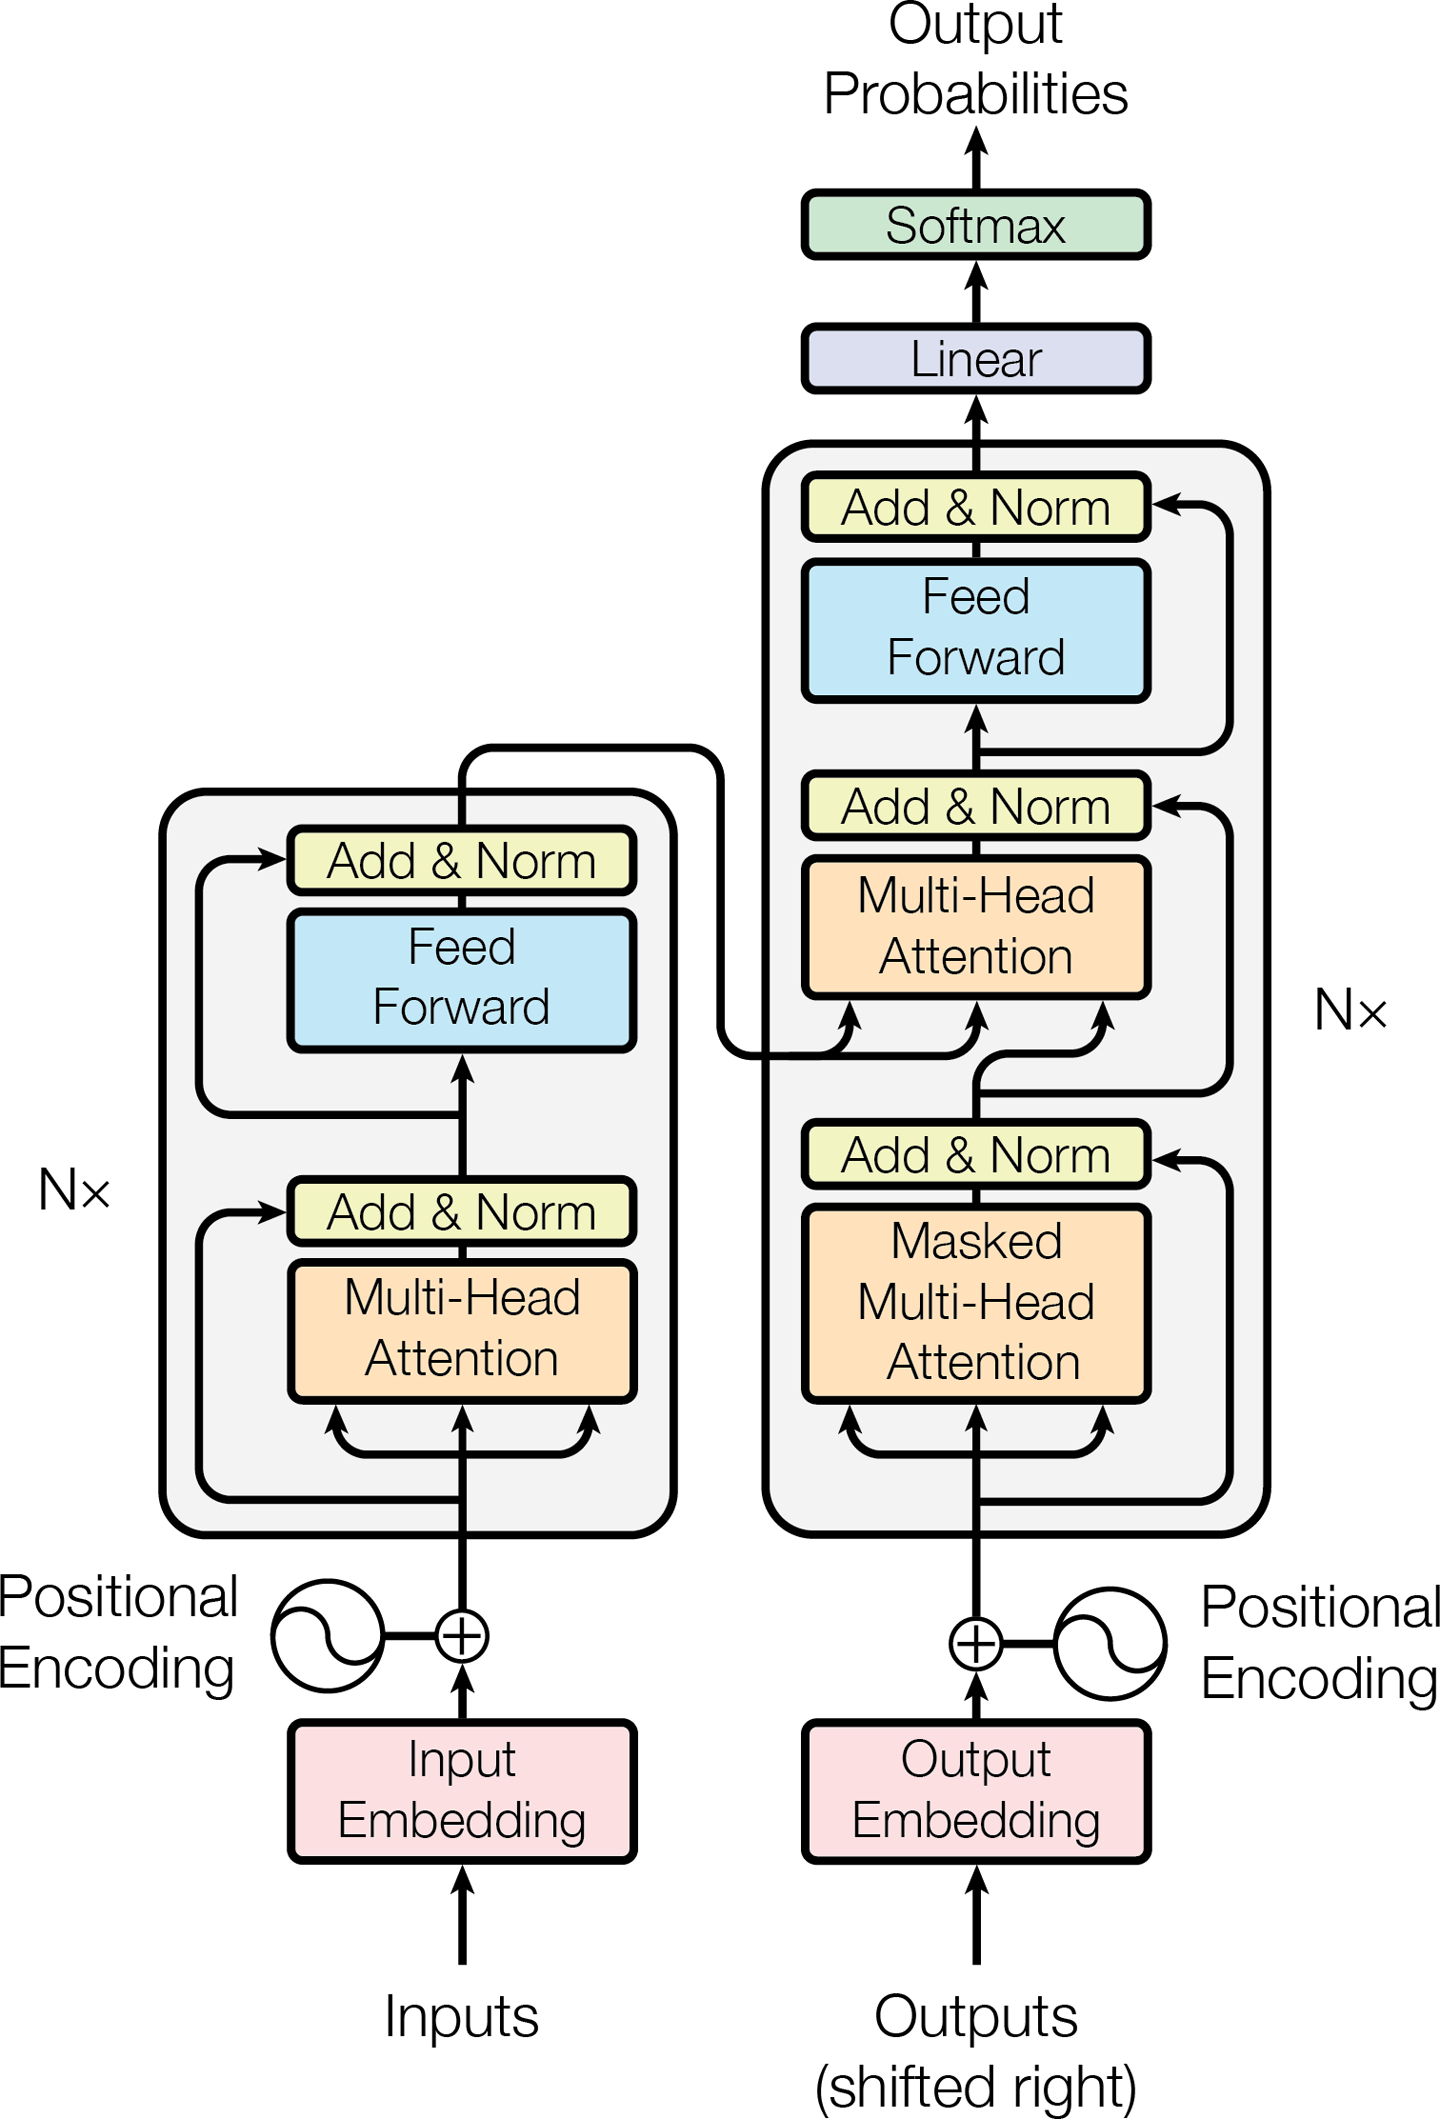

- The lefthand part is the encoder. Just like earlier, it takes as input a batch of sentences represented as sequences of word IDs (the input shape is [batch size, max input sentence length]), and it encodes each word into a 512-dimensional representation (so the encoder’s output shape is [batch size, max input sentence length, 512]). Note that the top part of the encoder is stacked N times (in the paper, N = 6).

- The righthand part is the decoder. During training, it takes the target sentence as input (also represented as a sequence of word IDs), shifted one time step to the right (i.e., a start-of-sequence token is inserted at the beginning). It also receives the outputs of the encoder (i.e., the arrows coming from the left side). Note that the top part of the decoder is also stacked N times, and the encoder stack’s final outputs are fed to the decoder at each of these N levels. Just like earlier, the decoder outputs a probability for each possible next word, at each time step (its output shape is [batch size, max output sentence length, vocabulary length]).

- During inference, the decoder cannot be fed targets, so we feed it the previously output words (starting with a start-of-sequence token). So the model needs to be called repeatedly, predicting one more word at every round (which is fed to the decoder at the next round, until the end-of-sequence token is output).

- Looking more closely, you can see that you are already familiar with most components: there are two embedding layers, 5 × N skip connections, each of them followed by a layer normalization layer, 2 × N “Feed Forward” modules that are composed of two dense layers each (the first one using the ReLU activation function, the second with no activation function), and finally the output layer is a dense layer using the softmax activation function. All of these layers are time-distributed, so each word is treated independently of all the others. But how can we translate a sentence by only looking at one word at a time? Well, that’s where the new components come in:

- The encoder’s Multi-Head Attention layer encodes each word’s relationship with every other word in the same sentence, paying more attention to the most relevant ones. For example, the output of this layer for the word “Queen” in the sentence “They welcomed the Queen of the United Kingdom” will depend on all the words in the sentence, but it will probably pay more attention to the words “United” and “Kingdom” than to the words “They” or “welcomed.” This attention mechanism is called self-attention (the sentence is paying attention to itself). We will discuss exactly how it works shortly. The decoder’s Masked Multi-Head Attention layer does the same thing, but each word is only allowed to attend to words located before it. Finally, the decoder’s upper Multi-Head Attention layer is where the decoder pays attention to the words in the input sentence. For example, the decoder will probably pay close attention to the word “Queen” in the input sentence when it is about to output this word’s translation.

- The positional encodings are simply dense vectors (much like word embeddings) that represent the position of a word in the sentence. The nth positional encoding is added to the word embedding of the nth word in each sentence. This gives the model access to each word’s position, which is needed because the Multi-Head Attention layers do not consider the order or the position of the words; they only look at their relationships. Since all the other layers are time-distributed, they have no way of knowing the position of each word (either relative or absolute). Obviously, the relative and absolute word positions are important, so we need to give this information to the Transformer somehow, and positional encodings are a good way to do this.

## Positional Encoding

A positional encoding is a dense vector that encodes the position of a word within a sentence: the ith positional encoding is simply added to the word embedding of the ith word in the sentence. These positional encodings can be learned by the model, but in the paper the authors preferred to use fixed positional encodings, defined using the sine and cosine functions of different frequencies. The positional encoding matrix P (also called PE) is defined in Equation 16-2 and represented at the top of Figure 16-9 (transposed), where Pp,i is the ith component of the encoding for the word located at the pth position in the sentence.

This solution gives the same performance as learned positional encodings do, but it can extend to arbitrarily long sentences, which is why it’s favored. After the positional encodings are added to the word embeddings, the rest of the model has access to the absolute position of each word in the sentence because there is a unique positional encoding for each position (e.g., the positional encoding for the word located at the 22nd position in a sentence is represented by the vertical dashed line at the bottom left of Figure 16-9, and you can see that it is unique to that position). Moreover, the choice of oscillating functions (sine and cosine) makes it possible for the model to learn relative positions as well. For example, words located 38 words apart (e.g., at positions p = 22 and p = 60) always have the same positional encoding values in the encoding dimensions i = 100 and i = 101, as you can see in Figure 16-9. This explains why we need both the sine and the cosine for each frequency: if we only used the sine (the blue wave at i = 100), the model would not be able to distinguish positions p = 22 and p = 35 (marked by a cross).

There is no PositionalEncoding layer in TensorFlow, but it is easy to create one. For efficiency reasons, we precompute the positional encoding matrix in the constructor (so we need to know the maximum sentence length, max_steps, and the number of dimensions for each word representation, max_dims). Then the call() method crops this encoding matrix to the size of the inputs, and it adds it to the inputs. Since we added an extra first dimension of size 1 when creating the positional encoding matrix, the rules of broadcasting will ensure that the matrix gets added to every sentence in the inputs:

### Positional Encoding

In [ ]:
class PositionalEncoding(keras.layers.Layer):
    def __init__(self, max_steps, max_dims, dtype=tf.float32, **kwargs):
        super().__init__(dtype=dtype, **kwargs)
        if max_dims % 2 == 1: max_dims += 1 # max_dims must be even
        p, i = np.meshgrid(np.arange(max_steps), np.arange(max_dims // 2))
        pos_emb = np.empty((1, max_steps, max_dims))
        pos_emb[0, :, ::2] = np.sin(p / 10000**(2 * i / max_dims)).T
        pos_emb[0, :, 1::2] = np.cos(p / 10000**(2 * i / max_dims)).T
        self.positional_embedding = tf.constant(pos_emb.astype(self.dtype))
    def call(self, inputs):
        shape = tf.shape(inputs)
        return inputs + self.positional_embedding[:, :shape[-2], :shape[-1]]

In [ ]:
max_steps = 201
max_dims = 512
pos_emb = PositionalEncoding(max_steps, max_dims)
PE = pos_emb(np.zeros((1, max_steps, max_dims), np.float32))[0].numpy()

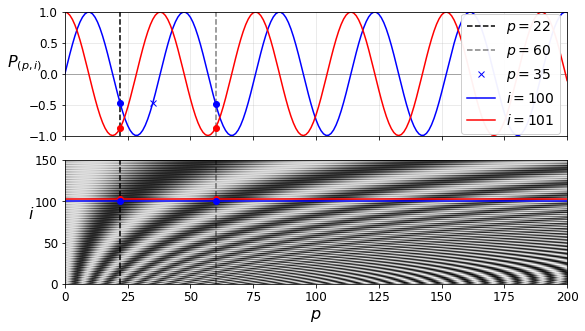

In [ ]:
i1, i2, crop_i = 100, 101, 150
p1, p2, p3 = 22, 60, 35
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(9, 5))
ax1.plot([p1, p1], [-1, 1], "k--", label="$p = {}$".format(p1))
ax1.plot([p2, p2], [-1, 1], "k--", label="$p = {}$".format(p2), alpha=0.5)
ax1.plot(p3, PE[p3, i1], "bx", label="$p = {}$".format(p3))
ax1.plot(PE[:,i1], "b-", label="$i = {}$".format(i1))
ax1.plot(PE[:,i2], "r-", label="$i = {}$".format(i2))
ax1.plot([p1, p2], [PE[p1, i1], PE[p2, i1]], "bo")
ax1.plot([p1, p2], [PE[p1, i2], PE[p2, i2]], "ro")
ax1.legend(loc="center right", fontsize=14, framealpha=0.95)
ax1.set_ylabel("$P_{(p,i)}$", rotation=0, fontsize=16)
ax1.grid(True, alpha=0.3)
ax1.hlines(0, 0, max_steps - 1, color="k", linewidth=1, alpha=0.3)
ax1.axis([0, max_steps - 1, -1, 1])
ax2.imshow(PE.T[:crop_i], cmap="gray", interpolation="bilinear", aspect="auto")
ax2.hlines(i1, 0, max_steps - 1, color="b")
cheat = 2 # need to raise the red line a bit, or else it hides the blue one
ax2.hlines(i2+cheat, 0, max_steps - 1, color="r")
ax2.plot([p1, p1], [0, crop_i], "k--")
ax2.plot([p2, p2], [0, crop_i], "k--", alpha=0.5)
ax2.plot([p1, p2], [i2+cheat, i2+cheat], "ro")
ax2.plot([p1, p2], [i1, i1], "bo")
ax2.axis([0, max_steps - 1, 0, crop_i])
ax2.set_xlabel("$p$", fontsize=16)
ax2.set_ylabel("$i$", rotation=0, fontsize=16)
save_fig("positional_embedding_plot")
plt.show()

Then we can create the first layers of the Transformer:

In [ ]:
embed_size = 512; max_steps = 500; vocab_size = 10000
encoder_inputs = keras.layers.Input(shape=[None], dtype=np.int32)
decoder_inputs = keras.layers.Input(shape=[None], dtype=np.int32)
embeddings = keras.layers.Embedding(vocab_size, embed_size)
encoder_embeddings = embeddings(encoder_inputs)
decoder_embeddings = embeddings(decoder_inputs)
positional_encoding = PositionalEncoding(max_steps, max_dims=embed_size)
encoder_in = positional_encoding(encoder_embeddings)
decoder_in = positional_encoding(decoder_embeddings)

## Multi Head Attention

To understand how a Multi-Head Attention layer works, we must first understand the Scaled Dot-Product Attention layer, which it is based on. Let’s suppose the encoder analyzed the input sentence “They played chess,” and it managed to understand that the word “They” is the subject and the word “played” is the verb, so it encoded this information in the representations of these words. Now suppose the decoder has already translated the subject, and it thinks that it should translate the verb next. For this, it needs to fetch the verb from the input sentence. This is analog to a dictionary lookup: it’s as if the encoder created a dictionary {“subject”: “They”, “verb”: “played”, …} and the decoder wanted to look up the value that corresponds to the key “verb.”

However, the model does not have discrete tokens to represent the keys (like “subject” or “verb”); it has vectorized representations of these concepts (which it learned during training), so the key it will use for the lookup (called the query) will not perfectly match any key in the dictionary. The solution is to compute a similarity measure between the query and each key in the dictionary, and then use the softmax function to convert these similarity scores to weights that add up to 1. If the key that represents the verb is by far the most similar to the query, then that key’s weight will be close to 1. Then the model can compute a weighted sum of the corresponding values, so if the weight of the “verb” key is close to 1, then the weighted sum will be very close to the representation of the word “played.” In short, you can think of this whole process as a differentiable dictionary lookup. 

The similarity measure used by the Transformer is just the dot product, like in Luong attention. In fact, the equation is the same as for Luong attention, except for a scaling factor. The equation is shown in Equation 16-3, in a vectorized form.

Attention(Q,K,V)=softmax(QK⊺/−−−−√dkeys)V




- Q is a matrix containing one row per query. Its shape is [nqueries, dkeys], where nqueries is the number of queries and dkeys is the number of dimensions of each query and each key.

- K is a matrix containing one row per key. Its shape is [nkeys, dkeys], where nkeys is the number of keys and values.

- V is a matrix containing one row per value. Its shape is [nkeys, dvalues], where dvalues is the number of dimensions of each value.

- The shape of Q K⊺ is [nqueries, nkeys]: it contains one similarity score for each query/key pair. The output of the softmax function has the same shape, but all rows sum up to 1. The final output has a shape of [nqueries, dvalues]: there is one row per query, where each row represents the query result (a weighted sum of the values).

- The scaling factor scales down the similarity scores to avoid saturating the softmax function, which would lead to tiny gradients.

- It is possible to mask out some key/value pairs by adding a very large negative value to the corresponding similarity scores, just before computing the softmax. This is useful in the Masked Multi-Head Attention layer.

In the encoder, this equation is applied to every input sentence in the batch, with Q, K, and V all equal to the list of words in the input sentence (so each word in the sentence will be compared to every word in the same sentence, including itself). Similarly, in the decoder’s masked attention layer, the equation will be applied to every target sentence in the batch, with Q, K, and V all equal to the list of words in the target sentence, but this time using a mask to prevent any word from comparing itself to words located after it (at inference time the decoder will only have access to the words it already output, not to future words, so during training we must mask out future output tokens). In the upper attention layer of the decoder, the keys K and values V are simply the list of word encodings produced by the encoder, and the queries Q are the list of word encodings produced by the decoder.

The keras.layers.Attention layer implements Scaled Dot-Product Attention, efficiently applying Equation 16-3 to multiple sentences in a batch. Its inputs are just like Q, K, and V, except with an extra batch dimension (the first dimension).

If we ignore the skip connections, the layer normalization layers, the Feed Forward blocks, and the fact that this is Scaled Dot-Product Attention, not exactly Multi-Head Attention, then the rest of the Transformer model can be implemented like this:

Here is a (very) simplified Transformer (the actual architecture has skip connections, layer norm, dense nets, and most importantly it uses Multi-Head Attention instead of regular Attention):

In [ ]:
Z = encoder_in
for N in range(6):
    Z = keras.layers.Attention(use_scale=True)([Z, Z])

encoder_outputs = Z
Z = decoder_in
for N in range(6):
    Z = keras.layers.Attention(use_scale=True, causal=True)([Z, Z])
    Z = keras.layers.Attention(use_scale=True)([Z, encoder_outputs])

outputs = keras.layers.TimeDistributed(
    keras.layers.Dense(vocab_size, activation="softmax"))(Z)

The use_scale=True argument creates an additional parameter that lets the layer learn how to properly downscale the similarity scores. This is a bit different from the Transformer model, which always downscales the similarity scores by the same factor (dkeys−−−−√dkeys<math xmlns="http://www.w3.org/1998/Math/MathML"><msqrt><msub><mi>d</mi> <mrow><mi>keys</mi></mrow></msub></msqrt></math>). The causal=True argument when creating the second attention layer ensures that each output token only attends to previous output tokens, not future ones.

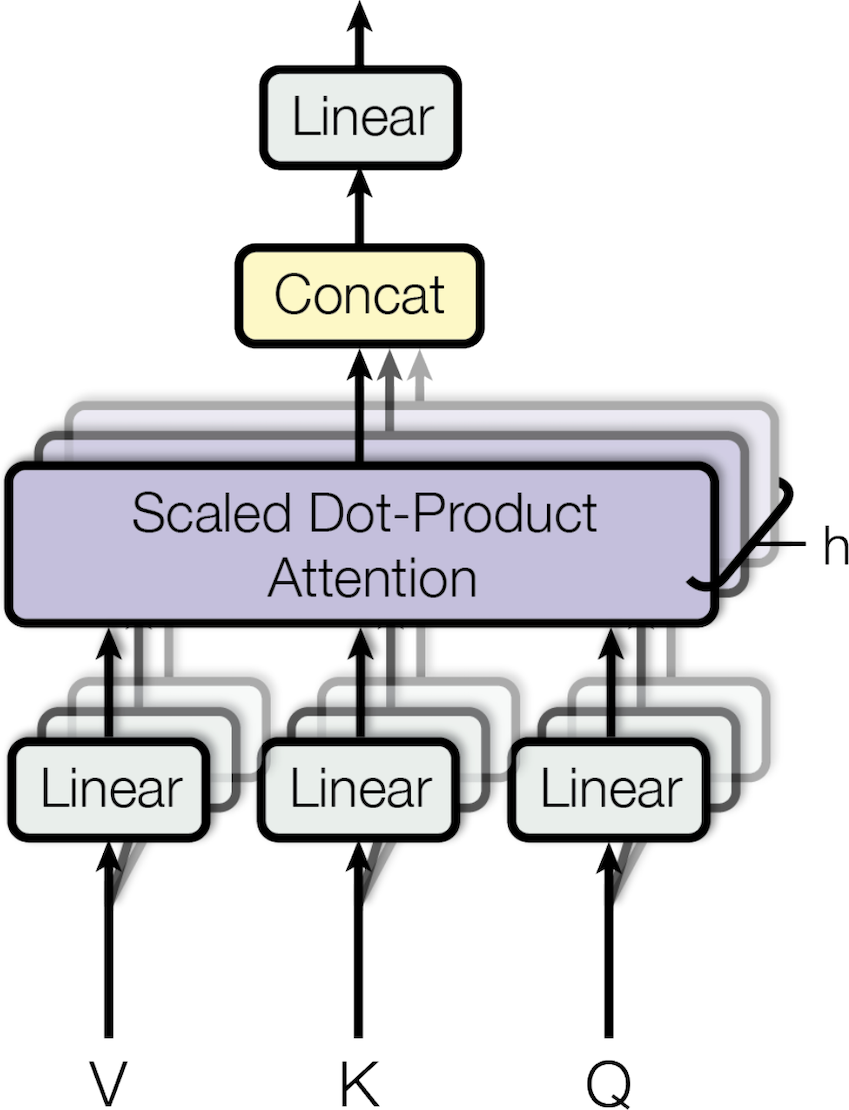

As you can see, it is just a bunch of Scaled Dot-Product Attention layers, each preceded by a linear transformation of the values, keys, and queries (i.e., a time-distributed Dense layer with no activation function). All the outputs are simply concatenated, and they go through a final linear transformation (again, time-distributed). But why? What is the intuition behind this architecture? Well, consider the word “played” we discussed earlier (in the sentence “They played chess”). The encoder was smart enough to encode the fact that it is a verb. But the word representation also includes its position in the text, thanks to the positional encodings, and it probably includes many other features that are useful for its translation, such as the fact that it is in the past tense. In short, the word representation encodes many different characteristics of the word. If we just used a single Scaled Dot-Product Attention layer, we would only be able to query all of these characteristics in one shot. This is why the Multi-Head Attention layer applies multiple different linear transformations of the values, keys, and queries: this allows the model to apply many differferent projections of the word representation into different subspaces, each focusing on a subset of the word’s characteristics. Perhaps one of the linear layers will project the word representation into a subspace where all that remains is the information that the word is a verb, another linear layer will extract just the fact that it is past tense, and so on. Then the Scaled Dot-Product Attention layers implement the lookup phase, and finally we concatenate all the results and project them back to the original space.

At the time of this writing, there is no Transformer class or MultiHeadAttention class available for TensorFlow 2. However, you can check out TensorFlow’s great tutorial for building a Transformer model for language understanding. Moreover, the TF Hub team is currently porting several Transformer-based modules to TensorFlow 2, and they should be available soon. In the meantime, I hope I have demonstrated that it is not that hard to implement a Transformer yourself, and it is certainly a great exercise!

Here's a basic implementation of the `MultiHeadAttention` layer. One will likely be added to `keras.layers` in the near future. Note that `Conv1D` layers with `kernel_size=1` (and the default `padding="valid"` and `strides=1`) is equivalent to a `TimeDistributed(Dense(...))` layer.

In [ ]:
K = keras.backend

class MultiHeadAttention(keras.layers.Layer):
    def __init__(self, n_heads, causal=False, use_scale=False, **kwargs):
        self.n_heads = n_heads
        self.causal = causal
        self.use_scale = use_scale
        super().__init__(**kwargs)
    def build(self, batch_input_shape):
        self.dims = batch_input_shape[0][-1]
        self.q_dims, self.v_dims, self.k_dims = [self.dims // self.n_heads] * 3 # could be hyperparameters instead
        self.q_linear = keras.layers.Conv1D(self.n_heads * self.q_dims, kernel_size=1, use_bias=False)
        self.v_linear = keras.layers.Conv1D(self.n_heads * self.v_dims, kernel_size=1, use_bias=False)
        self.k_linear = keras.layers.Conv1D(self.n_heads * self.k_dims, kernel_size=1, use_bias=False)
        self.attention = keras.layers.Attention(causal=self.causal, use_scale=self.use_scale)
        self.out_linear = keras.layers.Conv1D(self.dims, kernel_size=1, use_bias=False)
        super().build(batch_input_shape)
    def _multi_head_linear(self, inputs, linear):
        shape = K.concatenate([K.shape(inputs)[:-1], [self.n_heads, -1]])
        projected = K.reshape(linear(inputs), shape)
        perm = K.permute_dimensions(projected, [0, 2, 1, 3])
        return K.reshape(perm, [shape[0] * self.n_heads, shape[1], -1])
    def call(self, inputs):
        q = inputs[0]
        v = inputs[1]
        k = inputs[2] if len(inputs) > 2 else v
        shape = K.shape(q)
        q_proj = self._multi_head_linear(q, self.q_linear)
        v_proj = self._multi_head_linear(v, self.v_linear)
        k_proj = self._multi_head_linear(k, self.k_linear)
        multi_attended = self.attention([q_proj, v_proj, k_proj])
        shape_attended = K.shape(multi_attended)
        reshaped_attended = K.reshape(multi_attended, [shape[0], self.n_heads, shape_attended[1], shape_attended[2]])
        perm = K.permute_dimensions(reshaped_attended, [0, 2, 1, 3])
        concat = K.reshape(perm, [shape[0], shape_attended[1], -1])
        return self.out_linear(concat)

In [ ]:
Q = np.random.rand(2, 50, 512)
V = np.random.rand(2, 80, 512)
multi_attn = MultiHeadAttention(8)
multi_attn([Q, V]).shape


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.




If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



TensorShape([2, 50, 512])

# Exercise solutions

## 1. to 7.

### What are the pros and cons of using a stateful RNN versus a stateless RNN?

- Stateless RNNs can only capture patterns whose length is less than, or equal to, the size of the windows the RNN is trained on. Conversely, stateful RNNs can capture longer-term patterns. However, implementing a stateful RNN is much harder⁠—especially preparing the dataset properly. Moreover, stateful RNNs do not always work better, in part because consecutive batches are not independent and identically distributed (IID). Gradient Descent is not fond of non-IID datasets.

### Why do people use Encoder–Decoder RNNs rather than plain sequence-to-sequence RNNs for automatic translation?

- In general, if you translate a sentence one word at a time, the result will be terrible. For example, the French sentence “Je vous en prie” means “You are welcome,” but if you translate it one word at a time, you get “I you in pray.” Huh? It is much better to read the whole sentence first and then translate it. A plain sequence-to-sequence RNN would start translating a sentence immediately after reading the first word, while an Encoder–Decoder RNN will first read the whole sentence and then translate it. That said, one could imagine a plain sequence-to-sequence RNN that would output silence whenever it is unsure about what to say next (just like human translators do when they must translate a live broadcast)

### How can you deal with variable-length input sequences? What about variable-length output sequences?

- Variable-length input sequences can be handled by padding the shorter sequences so that all sequences in a batch have the same length, and using masking to ensure the RNN ignores the padding token. For better performance, you may also want to create batches containing sequences of similar sizes. Ragged tensors can hold sequences of variable lengths, and tf.keras will likely support them eventually, which will greatly simplify handling variable-length input sequences (at the time of this writing, it is not the case yet). Regarding variable-length output sequences, if the length of the output sequence is known in advance (e.g., if you know that it is the same as the input sequence), then you just need to configure the loss function so that it ignores tokens that come after the end of the sequence. Similarly, the code that will use the model should ignore tokens beyond the end of the sequence. But generally the length of the output sequence is not known ahead of time, so the solution is to train the model so that it outputs an end-of-sequence token at the end of each sequence.



### What is beam search and why would you use it? What tool can you use to implement it?

- Beam search is a technique used to improve the performance of a trained Encoder–Decoder model, for example in a neural machine translation system. The algorithm keeps track of a short list of the k most promising output sentences (say, the top three), and at each decoder step it tries to extend them by one word; then it keeps only the k most likely sentences. The parameter k is called the beam width: the larger it is, the more CPU and RAM will be used, but also the more accurate the system will be. Instead of greedily choosing the most likely next word at each step to extend a single sentence, this technique allows the system to explore several promising sentences simultaneously. Moreover, this technique lends itself well to parallelization. You can implement beam search fairly easily using TensorFlow Addons.


### What is an attention mechanism? How does it help?

- An attention mechanism is a technique initially used in Encoder–Decoder models to give the decoder more direct access to the input sequence, allowing it to deal with longer input sequences. At each decoder time step, the current decoder’s state and the full output of the encoder are processed by an alignment model that outputs an alignment score for each input time step. This score indicates which part of the input is most relevant to the current decoder time step. The weighted sum of the encoder output (weighted by their alignment score) is then fed to the decoder, which produces the next decoder state and the output for this time step. The main benefit of using an attention mechanism is the fact that the Encoder–Decoder model can successfully process longer input sequences. Another benefit is that the alignment scores makes the model easier to debug and interpret: for example, if the model makes a mistake, you can look at which part of the input it was paying attention to, and this can help diagnose the issue. An attention mechanism is also at the core of the Transformer architecture, in the Multi-Head Attention layers.


### What is the most important layer in the Transformer architecture? What is its purpose?

- The most important layer in the Transformer architecture is the Multi-Head Attention layer (the original Transformer architecture contains 18 of them, including 6 Masked Multi-Head Attention layers). It is at the core of language models such as BERT and GPT-2. Its purpose is to allow the model to identify which words are most aligned with each other, and then improve each word’s representation using these contextual clues.


### When would you need to use sampled softmax?

- Sampled softmax is used when training a classification model when there are many classes (e.g., thousands). It computes an approximation of the cross-entropy loss based on the logit predicted by the model for the correct class, and the predicted logits for a sample of incorrect words. This speeds up training considerably compared to computing the softmax over all logits and then estimating the cross-entropy loss. After training, the model can be used normally, using the regular softmax function to compute all the class probabilities based on all the logits.


See Appendix A.

## 8.
_Exercise:_ Embedded Reber grammars _were used by Hochreiter and Schmidhuber in [their paper](https://homl.info/93) about LSTMs. They are artificial grammars that produce strings such as "BPBTSXXVPSEPE." Check out Jenny Orr's [nice introduction](https://homl.info/108) to this topic. Choose a particular embedded Reber grammar (such as the one represented on Jenny Orr's page), then train an RNN to identify whether a string respects that grammar or not. You will first need to write a function capable of generating a training batch containing about 50% strings that respect the grammar, and 50% that don't._

First we need to build a function that generates strings based on a grammar. The grammar will be represented as a list of possible transitions for each state. A transition specifies the string to output (or a grammar to generate it) and the next state.

In [ ]:
default_reber_grammar = [
    [("B", 1)],           # (state 0) =B=>(state 1)
    [("T", 2), ("P", 3)], # (state 1) =T=>(state 2) or =P=>(state 3)
    [("S", 2), ("X", 4)], # (state 2) =S=>(state 2) or =X=>(state 4)
    [("T", 3), ("V", 5)], # and so on...
    [("X", 3), ("S", 6)],
    [("P", 4), ("V", 6)],
    [("E", None)]]        # (state 6) =E=>(terminal state)

embedded_reber_grammar = [
    [("B", 1)],
    [("T", 2), ("P", 3)],
    [(default_reber_grammar, 4)],
    [(default_reber_grammar, 5)],
    [("T", 6)],
    [("P", 6)],
    [("E", None)]]

def generate_string(grammar):
    state = 0
    output = []
    while state is not None:
        index = np.random.randint(len(grammar[state]))
        production, state = grammar[state][index]
        if isinstance(production, list):
            production = generate_string(grammar=production)
        output.append(production)
    return "".join(output)

Let's generate a few strings based on the default Reber grammar:

In [ ]:
np.random.seed(42)

for _ in range(25):
    print(generate_string(default_reber_grammar), end=" ")

BTXXTTVPXTVPXTTVPSE BPVPSE BTXSE BPVVE BPVVE BTSXSE BPTVPXTTTVVE BPVVE BTXSE BTXXVPSE BPTTTTTTTTVVE BTXSE BPVPSE BTXSE BPTVPSE BTXXTVPSE BPVVE BPVVE BPVVE BPTTVVE BPVVE BPVVE BTXXVVE BTXXVVE BTXXVPXVVE 

Looks good. Now let's generate a few strings based on the embedded Reber grammar:

In [ ]:
np.random.seed(42)

for _ in range(25):
    print(generate_string(embedded_reber_grammar), end=" ")

BTBPTTTVPXTVPXTTVPSETE BPBPTVPSEPE BPBPVVEPE BPBPVPXVVEPE BPBTXXTTTTVVEPE BPBPVPSEPE BPBTXXVPSEPE BPBTSSSSSSSXSEPE BTBPVVETE BPBTXXVVEPE BPBTXXVPSEPE BTBTXXVVETE BPBPVVEPE BPBPVVEPE BPBTSXSEPE BPBPVVEPE BPBPTVPSEPE BPBTXXVVEPE BTBPTVPXVVETE BTBPVVETE BTBTSSSSSSSXXVVETE BPBTSSSXXTTTTVPSEPE BTBPTTVVETE BPBTXXTVVEPE BTBTXSETE 

Okay, now we need a function to generate strings that do not respect the grammar. We could generate a random string, but the task would be a bit too easy, so instead we will generate a string that respects the grammar, and we will corrupt it by changing just one character:

In [ ]:
POSSIBLE_CHARS = "BEPSTVX"

def generate_corrupted_string(grammar, chars=POSSIBLE_CHARS):
    good_string = generate_string(grammar)
    index = np.random.randint(len(good_string))
    good_char = good_string[index]
    bad_char = np.random.choice(sorted(set(chars) - set(good_char)))
    return good_string[:index] + bad_char + good_string[index + 1:]

Let's look at a few corrupted strings:

In [ ]:
np.random.seed(42)

for _ in range(25):
    print(generate_corrupted_string(embedded_reber_grammar), end=" ")

BTBPTTTPPXTVPXTTVPSETE BPBTXEEPE BPBPTVVVEPE BPBTSSSSXSETE BPTTXSEPE BTBPVPXTTTTTTEVETE BPBTXXSVEPE BSBPTTVPSETE BPBXVVEPE BEBTXSETE BPBPVPSXPE BTBPVVVETE BPBTSXSETE BPBPTTTPTTTTTVPSEPE BTBTXXTTSTVPSETE BBBTXSETE BPBTPXSEPE BPBPVPXTTTTVPXTVPXVPXTTTVVEVE BTBXXXTVPSETE BEBTSSSSSXXVPXTVVETE BTBXTTVVETE BPBTXSTPE BTBTXXTTTVPSBTE BTBTXSETX BTBTSXSSTE 

We cannot feed strings directly to an RNN, so we need to encode them somehow. One option would be to one-hot encode each character. Another option is to use embeddings. Let's go for the second option (but since there are just a handful of characters, one-hot encoding would probably be a good option as well). For embeddings to work, we need to convert each string into a sequence of character IDs. Let's write a function for that, using each character's index in the string of possible characters "BEPSTVX":

In [ ]:
def string_to_ids(s, chars=POSSIBLE_CHARS):
    return [chars.index(c) for c in s]

In [ ]:
string_to_ids("BTTTXXVVETE")

[0, 4, 4, 4, 6, 6, 5, 5, 1, 4, 1]

We can now generate the dataset, with 50% good strings, and 50% bad strings:

In [ ]:
def generate_dataset(size):
    good_strings = [string_to_ids(generate_string(embedded_reber_grammar))
                    for _ in range(size // 2)]
    bad_strings = [string_to_ids(generate_corrupted_string(embedded_reber_grammar))
                   for _ in range(size - size // 2)]
    all_strings = good_strings + bad_strings
    X = tf.ragged.constant(all_strings, ragged_rank=1)
    y = np.array([[1.] for _ in range(len(good_strings))] +
                 [[0.] for _ in range(len(bad_strings))])
    return X, y

In [ ]:
np.random.seed(42)

X_train, y_train = generate_dataset(10000)
X_valid, y_valid = generate_dataset(2000)

Let's take a look at the first training sequence:

In [ ]:
X_train[0]

<tf.Tensor: shape=(22,), dtype=int32, numpy=
array([0, 4, 0, 2, 4, 4, 4, 5, 2, 6, 4, 5, 2, 6, 4, 4, 5, 2, 3, 1, 4, 1],
      dtype=int32)>

What class does it belong to?

In [ ]:
y_train[0]

array([1.])

Perfect! We are ready to create the RNN to identify good strings. We build a simple sequence binary classifier:

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

embedding_size = 5

model = keras.models.Sequential([
    keras.layers.InputLayer(input_shape=[None], dtype=tf.int32, ragged=True),
    keras.layers.Embedding(input_dim=len(POSSIBLE_CHARS), output_dim=embedding_size),
    keras.layers.GRU(30),
    keras.layers.Dense(1, activation="sigmoid")
])
optimizer = keras.optimizers.SGD(lr=0.02, momentum = 0.95, nesterov=True)
model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))

Train on 10000 samples, validate on 2000 samples
Epoch 1/20


/Users/ageron/miniconda3/envs/tf2/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/Users/ageron/miniconda3/envs/tf2/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


120278/10000 [========================================================================================================================================================================================================================================================================================================================================================================] - 5s 42us/sample - loss: 0.6847 - accuracy: 0.5138 - val_loss: 8.1518 - val_accuracy: 0.6115
Epoch 2/20
120278/10000 [========================================================================================================================================================================================================================================================================================================================================================================] - 3s 28us/sample - loss: 0.6524 - accuracy: 0.5571 - val_loss: 7.9259 - val_accuracy: 0.6085
Epoch 3/20
120278/10000 [==========================

Now let's test our RNN on two tricky strings: the first one is bad while the second one is good. They only differ by the second to last character. If the RNN gets this right, it shows that it managed to notice the pattern that the second letter should always be equal to the second to last letter. That requires a fairly long short-term memory (which is the reason why we used a GRU cell).

In [ ]:
test_strings = ["BPBTSSSSSSSXXTTVPXVPXTTTTTVVETE",
                "BPBTSSSSSSSXXTTVPXVPXTTTTTVVEPE"]
X_test = tf.ragged.constant([string_to_ids(s) for s in test_strings], ragged_rank=1)

y_proba = model.predict(X_test)
print()
print("Estimated probability that these are Reber strings:")
for index, string in enumerate(test_strings):
    print("{}: {:.2f}%".format(string, 100 * y_proba[index][0]))


Estimated probability that these are Reber strings:
BPBTSSSSSSSXXTTVPXVPXTTTTTVVETE: 0.40%
BPBTSSSSSSSXXTTVPXVPXTTTTTVVEPE: 99.96%


Ta-da! It worked fine. The RNN found the correct answers with very high confidence. :)

## 9.
_Exercise: Train an Encoder–Decoder model that can convert a date string from one format to another (e.g., from "April 22, 2019" to "2019-04-22")._

Let's start by creating the dataset. We will use random days between 1000-01-01 and 9999-12-31:

In [ ]:
from datetime import date

# cannot use strftime()'s %B format since it depends on the locale
MONTHS = ["January", "February", "March", "April", "May", "June",
          "July", "August", "September", "October", "November", "December"]

def random_dates(n_dates):
    min_date = date(1000, 1, 1).toordinal()
    max_date = date(9999, 12, 31).toordinal()

    ordinals = np.random.randint(max_date - min_date, size=n_dates) + min_date
    dates = [date.fromordinal(ordinal) for ordinal in ordinals]

    x = [MONTHS[dt.month - 1] + " " + dt.strftime("%d, %Y") for dt in dates]
    y = [dt.isoformat() for dt in dates]
    return x, y

Here are a few random dates, displayed in both the input format and the target format:

In [ ]:
np.random.seed(42)

n_dates = 3
x_example, y_example = random_dates(n_dates)
print("{:25s}{:25s}".format("Input", "Target"))
print("-" * 50)
for idx in range(n_dates):
    print("{:25s}{:25s}".format(x_example[idx], y_example[idx]))

Input                    Target                   
--------------------------------------------------
September 20, 7075       7075-09-20               
May 15, 8579             8579-05-15               
January 11, 7103         7103-01-11               


Let's get the list of all possible characters in the inputs:

In [ ]:
INPUT_CHARS = "".join(sorted(set("".join(MONTHS) + "0123456789, ")))
INPUT_CHARS

' ,0123456789ADFJMNOSabceghilmnoprstuvy'

And here's the list of possible characters in the outputs:

In [ ]:
OUTPUT_CHARS = "0123456789-"

Let's write a function to convert a string to a list of character IDs, as we did in the previous exercise:

In [ ]:
def date_str_to_ids(date_str, chars=INPUT_CHARS):
    return [chars.index(c) for c in date_str]

In [ ]:
date_str_to_ids(x_example[0], INPUT_CHARS)

[7, 11, 19, 22, 11, 16, 9, 11, 20, 38, 28, 26, 37, 38, 33, 26, 33, 31]

In [ ]:
date_str_to_ids(y_example[0], OUTPUT_CHARS)

[7, 0, 7, 5, 10, 0, 9, 10, 2, 0]

In [ ]:
def prepare_date_strs(date_strs, chars=INPUT_CHARS):
    X_ids = [date_str_to_ids(dt, chars) for dt in date_strs]
    X = tf.ragged.constant(X_ids, ragged_rank=1)
    return (X + 1).to_tensor() # using 0 as the padding token ID

def create_dataset(n_dates):
    x, y = random_dates(n_dates)
    return prepare_date_strs(x, INPUT_CHARS), prepare_date_strs(y, OUTPUT_CHARS)

In [ ]:
np.random.seed(42)

X_train, Y_train = create_dataset(10000)
X_valid, Y_valid = create_dataset(2000)
X_test, Y_test = create_dataset(2000)

In [ ]:
Y_train[0]

<tf.Tensor: shape=(10,), dtype=int32, numpy=array([ 8,  1,  8,  6, 11,  1, 10, 11,  3,  1], dtype=int32)>

### First version: a very basic seq2seq model

Let's first try the simplest possible model: we feed in the input sequence, which first goes through the encoder (an embedding layer followed by a single LSTM layer), which outputs a vector, then it goes through a decoder (a single LSTM layer, followed by a dense output layer), which outputs a sequence of vectors, each representing the estimated probabilities for all possible output character.

Since the decoder expects a sequence as input, we repeat the vector (which is output by the decoder) as many times as the longest possible output sequence.

In [ ]:
embedding_size = 32
max_output_length = Y_train.shape[1]

np.random.seed(42)
tf.random.set_seed(42)

encoder = keras.models.Sequential([
    keras.layers.Embedding(input_dim=len(INPUT_CHARS) + 1,
                           output_dim=embedding_size,
                           input_shape=[None]),
    keras.layers.LSTM(128)
])

decoder = keras.models.Sequential([
    keras.layers.LSTM(128, return_sequences=True),
    keras.layers.Dense(len(OUTPUT_CHARS) + 1, activation="softmax")
])

model = keras.models.Sequential([
    encoder,
    keras.layers.RepeatVector(max_output_length),
    decoder
])

optimizer = keras.optimizers.Nadam()
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
313/313 [==============================] - 6s 18ms/step - loss: 1.8111 - accuracy: 0.3533 - val_loss: 1.3581 - val_accuracy: 0.4965
Epoch 2/20
313/313 [==============================] - 5s 15ms/step - loss: 1.3518 - accuracy: 0.5103 - val_loss: 1.1915 - val_accuracy: 0.5694
Epoch 3/20
313/313 [==============================] - 5s 15ms/step - loss: 1.1706 - accuracy: 0.5908 - val_loss: 0.9983 - val_accuracy: 0.6398
Epoch 4/20
313/313 [==============================] - 5s 15ms/step - loss: 0.9158 - accuracy: 0.6686 - val_loss: 0.8012 - val_accuracy: 0.6987
Epoch 5/20
313/313 [==============================] - 5s 15ms/step - loss: 0.7058 - accuracy: 0.7308 - val_loss: 0.6224 - val_accuracy: 0.7599
Epoch 6/20
313/313 [==============================] - 5s 15ms/step - loss: 0.7756 - accuracy: 0.7203 - val_loss: 0.6541 - val_accuracy: 0.7599
Epoch 7/20
313/313 [==============================] - 5s 16ms/step - loss: 0.5379 - accuracy: 0.8034 - val_loss: 0.4174 - val_accuracy: 0.8440

Looks great, we reach 100% validation accuracy! Let's use the model to make some predictions. We will need to be able to convert a sequence of character IDs to a readable string:

In [ ]:
def ids_to_date_strs(ids, chars=OUTPUT_CHARS):
    return ["".join([("?" + chars)[index] for index in sequence])
            for sequence in ids]

Now we can use the model to convert some dates

In [ ]:
X_new = prepare_date_strs(["September 17, 2009", "July 14, 1789"])

In [ ]:
#ids = model.predict_classes(X_new)
ids = np.argmax(model.predict(X_new), axis=-1)
for date_str in ids_to_date_strs(ids):
    print(date_str)

2009-09-17
1789-07-14


Perfect! :)

However, since the model was only trained on input strings of length 18 (which is the length of the longest date), it does not perform well if we try to use it to make predictions on shorter sequences:

In [ ]:
X_new = prepare_date_strs(["May 02, 2020", "July 14, 1789"])

In [ ]:
#ids = model.predict_classes(X_new)
ids = np.argmax(model.predict(X_new), axis=-1)
for date_str in ids_to_date_strs(ids):
    print(date_str)

2020-01-02
1789-02-14


Oops! We need to ensure that we always pass sequences of the same length as during training, using padding if necessary. Let's write a little helper function for that:

In [ ]:
max_input_length = X_train.shape[1]

def prepare_date_strs_padded(date_strs):
    X = prepare_date_strs(date_strs)
    if X.shape[1] < max_input_length:
        X = tf.pad(X, [[0, 0], [0, max_input_length - X.shape[1]]])
    return X

def convert_date_strs(date_strs):
    X = prepare_date_strs_padded(date_strs)
    #ids = model.predict_classes(X)
    ids = np.argmax(model.predict(X), axis=-1)
    return ids_to_date_strs(ids)

In [ ]:
convert_date_strs(["May 02, 2020", "July 14, 1789"])

['2020-05-02', '1789-07-14']

Cool! Granted, there are certainly much easier ways to write a date conversion tool (e.g., using regular expressions or even basic string manipulation), but you have to admit that using neural networks is way cooler. ;-)

However, real-life sequence-to-sequence problems will usually be harder, so for the sake of completeness, let's build a more powerful model.

### Second version: feeding the shifted targets to the decoder (teacher forcing)

Instead of feeding the decoder a simple repetition of the encoder's output vector, we can feed it the target sequence, shifted by one time step to the right. This way, at each time step the decoder will know what the previous target character was. This should help is tackle more complex sequence-to-sequence problems.

Since the first output character of each target sequence has no previous character, we will need a new token to represent the start-of-sequence (sos).

During inference, we won't know the target, so what will we feed the decoder? We can just predict one character at a time, starting with an sos token, then feeding the decoder all the characters that were predicted so far (we will look at this in more details later in this notebook).

But if the decoder's LSTM expects to get the previous target as input at each step, how shall we pass it it the vector output by the encoder? Well, one option is to ignore the output vector, and instead use the encoder's LSTM state as the initial state of the decoder's LSTM (which requires that encoder's LSTM must have the same number of units as the decoder's LSTM).

Now let's create the decoder's inputs (for training, validation and testing). The sos token will be represented using the last possible output character's ID + 1.

In [ ]:
sos_id = len(OUTPUT_CHARS) + 1

def shifted_output_sequences(Y):
    sos_tokens = tf.fill(dims=(len(Y), 1), value=sos_id)
    return tf.concat([sos_tokens, Y[:, :-1]], axis=1)

X_train_decoder = shifted_output_sequences(Y_train)
X_valid_decoder = shifted_output_sequences(Y_valid)
X_test_decoder = shifted_output_sequences(Y_test)

Let's take a look at the decoder's training inputs:

In [ ]:
X_train_decoder

<tf.Tensor: shape=(10000, 10), dtype=int32, numpy=
array([[12,  8,  1, ..., 10, 11,  3],
       [12,  9,  6, ...,  6, 11,  2],
       [12,  8,  2, ...,  2, 11,  2],
       ...,
       [12, 10,  8, ...,  2, 11,  4],
       [12,  2,  2, ...,  3, 11,  3],
       [12,  8,  9, ...,  8, 11,  3]], dtype=int32)>

Now let's build the model. It's not a simple sequential model anymore, so let's use the functional API:

In [ ]:
encoder_embedding_size = 32
decoder_embedding_size = 32
lstm_units = 128

np.random.seed(42)
tf.random.set_seed(42)

encoder_input = keras.layers.Input(shape=[None], dtype=tf.int32)
encoder_embedding = keras.layers.Embedding(
    input_dim=len(INPUT_CHARS) + 1,
    output_dim=encoder_embedding_size)(encoder_input)
_, encoder_state_h, encoder_state_c = keras.layers.LSTM(
    lstm_units, return_state=True)(encoder_embedding)
encoder_state = [encoder_state_h, encoder_state_c]

decoder_input = keras.layers.Input(shape=[None], dtype=tf.int32)
decoder_embedding = keras.layers.Embedding(
    input_dim=len(OUTPUT_CHARS) + 2,
    output_dim=decoder_embedding_size)(decoder_input)
decoder_lstm_output = keras.layers.LSTM(lstm_units, return_sequences=True)(
    decoder_embedding, initial_state=encoder_state)
decoder_output = keras.layers.Dense(len(OUTPUT_CHARS) + 1,
                                    activation="softmax")(decoder_lstm_output)

model = keras.models.Model(inputs=[encoder_input, decoder_input],
                           outputs=[decoder_output])

optimizer = keras.optimizers.Nadam()
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit([X_train, X_train_decoder], Y_train, epochs=10,
                    validation_data=([X_valid, X_valid_decoder], Y_valid))

Epoch 1/10
313/313 [==============================] - 5s 17ms/step - loss: 1.6898 - accuracy: 0.3714 - val_loss: 1.4141 - val_accuracy: 0.4603
Epoch 2/10
313/313 [==============================] - 5s 15ms/step - loss: 1.2118 - accuracy: 0.5541 - val_loss: 0.9360 - val_accuracy: 0.6653
Epoch 3/10
313/313 [==============================] - 5s 15ms/step - loss: 0.6399 - accuracy: 0.7766 - val_loss: 0.4054 - val_accuracy: 0.8631
Epoch 4/10
313/313 [==============================] - 5s 15ms/step - loss: 0.2207 - accuracy: 0.9463 - val_loss: 0.1069 - val_accuracy: 0.9869
Epoch 5/10
313/313 [==============================] - 5s 15ms/step - loss: 0.0805 - accuracy: 0.9910 - val_loss: 0.0445 - val_accuracy: 0.9976
Epoch 6/10
313/313 [==============================] - 5s 15ms/step - loss: 0.0297 - accuracy: 0.9993 - val_loss: 0.0237 - val_accuracy: 0.9992
Epoch 7/10
313/313 [==============================] - 5s 15ms/step - loss: 0.0743 - accuracy: 0.9857 - val_loss: 0.0702 - val_accuracy: 0.9889

This model also reaches 100% validation accuracy, but it does so even faster.

Let's once again use the model to make some predictions. This time we need to predict characters one by one.

In [ ]:
sos_id = len(OUTPUT_CHARS) + 1

def predict_date_strs(date_strs):
    X = prepare_date_strs_padded(date_strs)
    Y_pred = tf.fill(dims=(len(X), 1), value=sos_id)
    for index in range(max_output_length):
        pad_size = max_output_length - Y_pred.shape[1]
        X_decoder = tf.pad(Y_pred, [[0, 0], [0, pad_size]])
        Y_probas_next = model.predict([X, X_decoder])[:, index:index+1]
        Y_pred_next = tf.argmax(Y_probas_next, axis=-1, output_type=tf.int32)
        Y_pred = tf.concat([Y_pred, Y_pred_next], axis=1)
    return ids_to_date_strs(Y_pred[:, 1:])

In [ ]:
predict_date_strs(["July 14, 1789", "May 01, 2020"])

['1789-07-14', '2020-05-01']

Works fine! :)

### Third version: using TF-Addons's seq2seq implementation

Let's build exactly the same model, but using TF-Addon's seq2seq API. The implementation below is almost very similar to the TFA example higher in this notebook, except without the model input to specify the output sequence length, for simplicity (but you can easily add it back in if you need it for your projects, when the output sequences have very different lengths).

In [ ]:
import tensorflow_addons as tfa

np.random.seed(42)
tf.random.set_seed(42)

encoder_embedding_size = 32
decoder_embedding_size = 32
units = 128

encoder_inputs = keras.layers.Input(shape=[None], dtype=np.int32)
decoder_inputs = keras.layers.Input(shape=[None], dtype=np.int32)
sequence_lengths = keras.layers.Input(shape=[], dtype=np.int32)

encoder_embeddings = keras.layers.Embedding(
    len(INPUT_CHARS) + 1, encoder_embedding_size)(encoder_inputs)

decoder_embedding_layer = keras.layers.Embedding(
    len(OUTPUT_CHARS) + 2, decoder_embedding_size)
decoder_embeddings = decoder_embedding_layer(decoder_inputs)

encoder = keras.layers.LSTM(units, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_embeddings)
encoder_state = [state_h, state_c]

sampler = tfa.seq2seq.sampler.TrainingSampler()

decoder_cell = keras.layers.LSTMCell(units)
output_layer = keras.layers.Dense(len(OUTPUT_CHARS) + 1)

decoder = tfa.seq2seq.basic_decoder.BasicDecoder(decoder_cell,
                                                 sampler,
                                                 output_layer=output_layer)
final_outputs, final_state, final_sequence_lengths = decoder(
    decoder_embeddings,
    initial_state=encoder_state)
Y_proba = keras.layers.Activation("softmax")(final_outputs.rnn_output)

model = keras.models.Model(inputs=[encoder_inputs, decoder_inputs],
                           outputs=[Y_proba])
optimizer = keras.optimizers.Nadam()
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit([X_train, X_train_decoder], Y_train, epochs=15,
                    validation_data=([X_valid, X_valid_decoder], Y_valid))

Epoch 1/15
313/313 [==============================] - 5s 17ms/step - loss: 1.6757 - accuracy: 0.3683 - val_loss: 1.4602 - val_accuracy: 0.4214
Epoch 2/15
313/313 [==============================] - 5s 15ms/step - loss: 1.3873 - accuracy: 0.4566 - val_loss: 1.2904 - val_accuracy: 0.4957
Epoch 3/15
313/313 [==============================] - 5s 15ms/step - loss: 1.0471 - accuracy: 0.6109 - val_loss: 0.7737 - val_accuracy: 0.7276
Epoch 4/15
313/313 [==============================] - 5s 15ms/step - loss: 0.5056 - accuracy: 0.8296 - val_loss: 0.2695 - val_accuracy: 0.9305
Epoch 5/15
313/313 [==============================] - 5s 15ms/step - loss: 0.1677 - accuracy: 0.9657 - val_loss: 0.0870 - val_accuracy: 0.9912
Epoch 6/15
313/313 [==============================] - 5s 15ms/step - loss: 0.1007 - accuracy: 0.9850 - val_loss: 0.0492 - val_accuracy: 0.9975
Epoch 7/15
313/313 [==============================] - 5s 15ms/step - loss: 0.0308 - accuracy: 0.9993 - val_loss: 0.0228 - val_accuracy: 0.9996

And once again, 100% validation accuracy! To use the model, we can just reuse the `predict_date_strs()` function:

In [ ]:
predict_date_strs(["July 14, 1789", "May 01, 2020"])

['1789-07-14', '2020-05-01']

However, there's a much more efficient way to perform inference. Until now, during inference, we've run the model once for each new character. Instead, we can create a new decoder, based on the previously trained layers, but using a `GreedyEmbeddingSampler` instead of a `TrainingSampler`.

At each time step, the `GreedyEmbeddingSampler` will compute the argmax of the decoder's outputs, and run the resulting token IDs through the decoder's embedding layer. Then it will feed the resulting embeddings to the decoder's LSTM cell at the next time step. This way, we only need to run the decoder once to get the full prediction.

In [ ]:
inference_sampler = tfa.seq2seq.sampler.GreedyEmbeddingSampler(
    embedding_fn=decoder_embedding_layer)
inference_decoder = tfa.seq2seq.basic_decoder.BasicDecoder(
    decoder_cell, inference_sampler, output_layer=output_layer,
    maximum_iterations=max_output_length)
batch_size = tf.shape(encoder_inputs)[:1]
start_tokens = tf.fill(dims=batch_size, value=sos_id)
final_outputs, final_state, final_sequence_lengths = inference_decoder(
    start_tokens,
    initial_state=encoder_state,
    start_tokens=start_tokens,
    end_token=0)

inference_model = keras.models.Model(inputs=[encoder_inputs],
                                     outputs=[final_outputs.sample_id])

A few notes:
* The `GreedyEmbeddingSampler` needs the `start_tokens` (a vector containing the start-of-sequence ID for each decoder sequence), and the `end_token` (the decoder will stop decoding a sequence once the model outputs this token).
* We must set `maximum_iterations` when creating the `BasicDecoder`, or else it may run into an infinite loop (if the model never outputs the end token for at least one of the sequences). This would force you would to restart the Jupyter kernel.
* The decoder inputs are not needed anymore, since all the decoder inputs are generated dynamically based on the outputs from the previous time step.
* The model's outputs are `final_outputs.sample_id` instead of the softmax of `final_outputs.rnn_outputs`. This allows us to directly get the argmax of the model's outputs. If you prefer to have access to the logits, you can replace `final_outputs.sample_id` with `final_outputs.rnn_outputs`.

Now we can write a simple function that uses the model to perform the date format conversion:

In [ ]:
def fast_predict_date_strs(date_strs):
    X = prepare_date_strs_padded(date_strs)
    Y_pred = inference_model.predict(X)
    return ids_to_date_strs(Y_pred)

In [ ]:
fast_predict_date_strs(["July 14, 1789", "May 01, 2020"])

['1789-07-14', '2020-05-01']

Let's check that it really is faster:

In [ ]:
%timeit predict_date_strs(["July 14, 1789", "May 01, 2020"])

199 ms ± 3.94 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
%timeit fast_predict_date_strs(["July 14, 1789", "May 01, 2020"])

18.3 ms ± 366 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


That's more than a 10x speedup! And it would be even more if we were handling longer sequences.

### Fourth version: using TF-Addons's seq2seq implementation with a scheduled sampler

**Warning**: due to a TF bug, this version only works using TensorFlow 2.2 or above.

When we trained the previous model, at each time step _t_ we gave the model the target token for time step _t_ - 1. However, at inference time, the model did not get the previous target at each time step. Instead, it got the previous prediction. So there is a discrepancy between training and inference, which may lead to disappointing performance. To alleviate this, we can gradually replace the targets with the predictions, during training. For this, we just need to replace the `TrainingSampler` with a `ScheduledEmbeddingTrainingSampler`, and use a Keras callback to gradually increase the `sampling_probability` (i.e., the probability that the decoder will use the prediction from the previous time step rather than the target for the previous time step).

In [ ]:
import tensorflow_addons as tfa

np.random.seed(42)
tf.random.set_seed(42)

n_epochs = 20
encoder_embedding_size = 32
decoder_embedding_size = 32
units = 128

encoder_inputs = keras.layers.Input(shape=[None], dtype=np.int32)
decoder_inputs = keras.layers.Input(shape=[None], dtype=np.int32)
sequence_lengths = keras.layers.Input(shape=[], dtype=np.int32)

encoder_embeddings = keras.layers.Embedding(
    len(INPUT_CHARS) + 1, encoder_embedding_size)(encoder_inputs)

decoder_embedding_layer = keras.layers.Embedding(
    len(OUTPUT_CHARS) + 2, decoder_embedding_size)
decoder_embeddings = decoder_embedding_layer(decoder_inputs)

encoder = keras.layers.LSTM(units, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_embeddings)
encoder_state = [state_h, state_c]

sampler = tfa.seq2seq.sampler.ScheduledEmbeddingTrainingSampler(
    sampling_probability=0.,
    embedding_fn=decoder_embedding_layer)
# we must set the sampling_probability after creating the sampler
# (see https://github.com/tensorflow/addons/pull/1714)
sampler.sampling_probability = tf.Variable(0.)

decoder_cell = keras.layers.LSTMCell(units)
output_layer = keras.layers.Dense(len(OUTPUT_CHARS) + 1)

decoder = tfa.seq2seq.basic_decoder.BasicDecoder(decoder_cell,
                                                 sampler,
                                                 output_layer=output_layer)
final_outputs, final_state, final_sequence_lengths = decoder(
    decoder_embeddings,
    initial_state=encoder_state)
Y_proba = keras.layers.Activation("softmax")(final_outputs.rnn_output)

model = keras.models.Model(inputs=[encoder_inputs, decoder_inputs],
                           outputs=[Y_proba])
optimizer = keras.optimizers.Nadam()
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])

def update_sampling_probability(epoch, logs):
    proba = min(1.0, epoch / (n_epochs - 10))
    sampler.sampling_probability.assign(proba)

sampling_probability_cb = keras.callbacks.LambdaCallback(
    on_epoch_begin=update_sampling_probability)
history = model.fit([X_train, X_train_decoder], Y_train, epochs=n_epochs,
                    validation_data=([X_valid, X_valid_decoder], Y_valid),
                    callbacks=[sampling_probability_cb])

Epoch 1/20


/Users/ageron/miniconda3/envs/tf2/lib/python3.7/site-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


313/313 [==============================] - 6s 19ms/step - loss: 1.6759 - accuracy: 0.3681 - val_loss: 1.4611 - val_accuracy: 0.4198
Epoch 2/20
313/313 [==============================] - 5s 17ms/step - loss: 1.3872 - accuracy: 0.4583 - val_loss: 1.2827 - val_accuracy: 0.5021
Epoch 3/20
313/313 [==============================] - 5s 17ms/step - loss: 1.0425 - accuracy: 0.6152 - val_loss: 0.8165 - val_accuracy: 0.7000
Epoch 4/20
313/313 [==============================] - 5s 17ms/step - loss: 0.6353 - accuracy: 0.7673 - val_loss: 0.4365 - val_accuracy: 0.8464
Epoch 5/20
313/313 [==============================] - 5s 17ms/step - loss: 0.3764 - accuracy: 0.8765 - val_loss: 0.2795 - val_accuracy: 0.9166
Epoch 6/20
313/313 [==============================] - 5s 17ms/step - loss: 0.2506 - accuracy: 0.9269 - val_loss: 0.1805 - val_accuracy: 0.9489
Epoch 7/20
313/313 [==============================] - 5s 17ms/step - loss: 0.1427 - accuracy: 0.9625 - val_loss: 0.1115 - val_accuracy: 0.9718
Epoch 8/20

Not quite 100% validation accuracy, but close enough!

For inference, we could do the exact same thing as earlier, using a `GreedyEmbeddingSampler`. However, just for the sake of completeness, let's use a `SampleEmbeddingSampler` instead. It's almost the same thing, except that instead of using the argmax of the model's output to find the token ID, it treats the outputs as logits and uses them to sample a token ID randomly. This can be useful when you want to generate text. The `softmax_temperature` argument serves the 
same purpose as when we generated Shakespeare-like text (the higher this argument, the more random the generated text will be).

In [ ]:
softmax_temperature = tf.Variable(1.)

inference_sampler = tfa.seq2seq.sampler.SampleEmbeddingSampler(
    embedding_fn=decoder_embedding_layer,
    softmax_temperature=softmax_temperature)
inference_decoder = tfa.seq2seq.basic_decoder.BasicDecoder(
    decoder_cell, inference_sampler, output_layer=output_layer,
    maximum_iterations=max_output_length)
batch_size = tf.shape(encoder_inputs)[:1]
start_tokens = tf.fill(dims=batch_size, value=sos_id)
final_outputs, final_state, final_sequence_lengths = inference_decoder(
    start_tokens,
    initial_state=encoder_state,
    start_tokens=start_tokens,
    end_token=0)

inference_model = keras.models.Model(inputs=[encoder_inputs],
                                     outputs=[final_outputs.sample_id])

In [ ]:
def creative_predict_date_strs(date_strs, temperature=1.0):
    softmax_temperature.assign(temperature)
    X = prepare_date_strs_padded(date_strs)
    Y_pred = inference_model.predict(X)
    return ids_to_date_strs(Y_pred)

In [ ]:
tf.random.set_seed(42)

creative_predict_date_strs(["July 14, 1789", "May 01, 2020"])

['1789-07-14', '2020-05-01']

Dates look good at room temperature. Now let's heat things up a bit:

In [ ]:
tf.random.set_seed(42)

creative_predict_date_strs(["July 14, 1789", "May 01, 2020"],
                           temperature=5.)

['2289607-12', '9272-03-01']

Oops, the dates are overcooked, now. Let's call them "creative" dates.

### Fifth version: using TFA seq2seq, the Keras subclassing API and attention mechanisms

The sequences in this problem are pretty short, but if we wanted to tackle longer sequences, we would probably have to use attention mechanisms. While it's possible to code our own implementation, it's simpler and more efficient to use TF-Addons's implementation instead. Let's do that now, this time using Keras' subclassing API.

**Warning**: due to a TensorFlow bug (see [this issue](https://github.com/tensorflow/addons/issues/1153) for details), the `get_initial_state()` method fails in eager mode, so for now we have to use the subclassing API, as Keras automatically calls `tf.function()` on the `call()` method (so it runs in graph mode).

In this implementation, we've reverted back to using the `TrainingSampler`, for simplicity (but you can easily tweak it to use a `ScheduledEmbeddingTrainingSampler` instead). We also use a `GreedyEmbeddingSampler` during inference, so this class is pretty easy to use:

In [ ]:
class DateTranslation(keras.models.Model):
    def __init__(self, units=128, encoder_embedding_size=32,
                 decoder_embedding_size=32, **kwargs):
        super().__init__(**kwargs)
        self.encoder_embedding = keras.layers.Embedding(
            input_dim=len(INPUT_CHARS) + 1,
            output_dim=encoder_embedding_size)
        self.encoder = keras.layers.LSTM(units,
                                         return_sequences=True,
                                         return_state=True)
        self.decoder_embedding = keras.layers.Embedding(
            input_dim=len(OUTPUT_CHARS) + 2,
            output_dim=decoder_embedding_size)
        self.attention = tfa.seq2seq.LuongAttention(units)
        decoder_inner_cell = keras.layers.LSTMCell(units)
        self.decoder_cell = tfa.seq2seq.AttentionWrapper(
            cell=decoder_inner_cell,
            attention_mechanism=self.attention)
        output_layer = keras.layers.Dense(len(OUTPUT_CHARS) + 1)
        self.decoder = tfa.seq2seq.BasicDecoder(
            cell=self.decoder_cell,
            sampler=tfa.seq2seq.sampler.TrainingSampler(),
            output_layer=output_layer)
        self.inference_decoder = tfa.seq2seq.BasicDecoder(
            cell=self.decoder_cell,
            sampler=tfa.seq2seq.sampler.GreedyEmbeddingSampler(
                embedding_fn=self.decoder_embedding),
            output_layer=output_layer,
            maximum_iterations=max_output_length)

    def call(self, inputs, training=None):
        encoder_input, decoder_input = inputs
        encoder_embeddings = self.encoder_embedding(encoder_input)
        encoder_outputs, encoder_state_h, encoder_state_c = self.encoder(
            encoder_embeddings,
            training=training)
        encoder_state = [encoder_state_h, encoder_state_c]

        self.attention(encoder_outputs,
                       setup_memory=True)
        
        decoder_embeddings = self.decoder_embedding(decoder_input)

        decoder_initial_state = self.decoder_cell.get_initial_state(
            decoder_embeddings)
        decoder_initial_state = decoder_initial_state.clone(
            cell_state=encoder_state)
        
        if training:
            decoder_outputs, _, _ = self.decoder(
                decoder_embeddings,
                initial_state=decoder_initial_state,
                training=training)
        else:
            start_tokens = tf.zeros_like(encoder_input[:, 0]) + sos_id
            decoder_outputs, _, _ = self.inference_decoder(
                decoder_embeddings,
                initial_state=decoder_initial_state,
                start_tokens=start_tokens,
                end_token=0)

        return tf.nn.softmax(decoder_outputs.rnn_output)

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

model = DateTranslation()
optimizer = keras.optimizers.Nadam()
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit([X_train, X_train_decoder], Y_train, epochs=25,
                    validation_data=([X_valid, X_valid_decoder], Y_valid))

Epoch 1/25
313/313 [==============================] - 7s 21ms/step - loss: 2.1549 - accuracy: 0.2295 - val_loss: 2.1450 - val_accuracy: 0.2239
Epoch 2/25
313/313 [==============================] - 6s 19ms/step - loss: 1.8147 - accuracy: 0.3492 - val_loss: 1.4931 - val_accuracy: 0.4476
Epoch 3/25
313/313 [==============================] - 6s 18ms/step - loss: 1.3585 - accuracy: 0.4909 - val_loss: 1.3168 - val_accuracy: 0.5100
Epoch 4/25
313/313 [==============================] - 6s 18ms/step - loss: 1.2787 - accuracy: 0.5293 - val_loss: 1.1767 - val_accuracy: 0.5624
Epoch 5/25
313/313 [==============================] - 6s 18ms/step - loss: 1.1236 - accuracy: 0.5776 - val_loss: 1.0769 - val_accuracy: 0.5907
Epoch 6/25
313/313 [==============================] - 6s 18ms/step - loss: 1.0369 - accuracy: 0.6073 - val_loss: 1.0159 - val_accuracy: 0.6199
Epoch 7/25
313/313 [==============================] - 6s 18ms/step - loss: 0.9752 - accuracy: 0.6295 - val_loss: 0.9723 - val_accuracy: 0.6346

Not quite 100% validation accuracy, but close. It took a bit longer to converge this time, but there were also more parameters and more computations per iteration. And we did not use a scheduled sampler.

To use the model, we can write yet another little function:

In [ ]:
def fast_predict_date_strs_v2(date_strs):
    X = prepare_date_strs_padded(date_strs)
    X_decoder = tf.zeros(shape=(len(X), max_output_length), dtype=tf.int32)
    Y_probas = model.predict([X, X_decoder])
    Y_pred = tf.argmax(Y_probas, axis=-1)
    return ids_to_date_strs(Y_pred)

In [ ]:
fast_predict_date_strs_v2(["July 14, 1789", "May 01, 2020"])

['1789-07-14', '2020-05-01']

There are still a few interesting features from TF-Addons that you may want to look at:
* Using a `BeamSearchDecoder` rather than a `BasicDecoder` for inference. Instead of outputing the character with the highest probability, this decoder keeps track of the several candidates, and keeps only the most likely sequences of candidates (see chapter 16 in the book for more details).
* Setting masks or specifying `sequence_length` if the input or target sequences may have very different lengths.
* Using a `ScheduledOutputTrainingSampler`, which gives you more flexibility than the `ScheduledEmbeddingTrainingSampler` to decide how to feed the output at time _t_ to the cell at time _t_+1. By default it feeds the outputs directly to cell, without computing the argmax ID and passing it through an embedding layer. Alternatively, you specify a `next_inputs_fn` function that will be used to convert the cell outputs to inputs at the next step.

## 10.
_Exercise: Go through TensorFlow's [Neural Machine Translation with Attention tutorial](https://homl.info/nmttuto)._

Simply open the Colab and follow its instructions. Alternatively, if you want a simpler example of using TF-Addons's seq2seq implementation for Neural Machine Translation (NMT), look at the solution to the previous question. The last model implementation will give you a simpler example of using TF-Addons to build an NMT model using attention mechanisms.

## 11.
_Exercise: Use one of the recent language models (e.g., GPT) to generate more convincing Shakespearean text._

The simplest way to use recent language models is to use the excellent [transformers library](https://huggingface.co/transformers/), open sourced by Hugging Face. It provides many modern neural net architectures (including BERT, GPT-2, RoBERTa, XLM, DistilBert, XLNet and more) for Natural Language Processing (NLP), including many pretrained models. It relies on either TensorFlow or PyTorch. Best of all: it's amazingly simple to use.

First, let's load a pretrained model. In this example, we will use OpenAI's GPT model, with an additional Language Model on top (just a linear layer with weights tied to the input embeddings). Let's import it and load the pretrained weights (this will download about 445MB of data to `~/.cache/torch/transformers`):

In [ ]:
from transformers import TFOpenAIGPTLMHeadModel

model = TFOpenAIGPTLMHeadModel.from_pretrained("openai-gpt")

Next we will need a specialized tokenizer for this model. This one will try to use the [spaCy](https://spacy.io/) and [ftfy](https://pypi.org/project/ftfy/) libraries if they are installed, or else it will fall back to BERT's `BasicTokenizer` followed by Byte-Pair Encoding (which should be fine for most use cases).

In [ ]:
from transformers import OpenAIGPTTokenizer

tokenizer = OpenAIGPTTokenizer.from_pretrained("openai-gpt")

Now let's use the tokenizer to tokenize and encode the prompt text:

In [ ]:
prompt_text = "This royal throne of kings, this sceptred isle"
encoded_prompt = tokenizer.encode(prompt_text,
                                  add_special_tokens=False,
                                  return_tensors="tf")
encoded_prompt

<tf.Tensor: shape=(1, 10), dtype=int32, numpy=
array([[  616,  5751,  6404,   498,  9606,   240,   616, 26271,  7428,
        16187]], dtype=int32)>

Easy! Next, let's use the model to generate text after the prompt. We will generate 5 different sentences, each starting with the prompt text, followed by 40 additional tokens. For an explanation of what all the hyperparameters do, make sure to check out this great [blog post](https://huggingface.co/blog/how-to-generate) by Patrick von Platen (from Hugging Face). You can play around with the hyperparameters to try to obtain better results.

In [ ]:
num_sequences = 5
length = 40

generated_sequences = model.generate(
    input_ids=encoded_prompt,
    do_sample=True,
    max_length=length + len(encoded_prompt[0]),
    temperature=1.0,
    top_k=0,
    top_p=0.9,
    repetition_penalty=1.0,
    num_return_sequences=num_sequences,
)

generated_sequences

<tf.Tensor: shape=(5, 50), dtype=int32, numpy=
array([[  616,  5751,  6404,   498,  9606,   240,   616, 26271,  7428,
        16187,   239,   784,   645,  1184,   558,  1886,   688,  6437,
          240,   784,   645,   507,   641,  5486,   240,   600,   636,
          868,   604,   694,  2816,   485,  1894,   822,   481,  1491,
          600,   880,  6061,   239,   256, 40477,   256,   600,   635,
          538,   604,  1816,   525,   239],
       [  616,  5751,  6404,   498,  9606,   240,   616, 26271,  7428,
        16187,   488,  1288,   989,   640, 16605,   239,   256, 40477,
          674,   481, 12744,  3912,   488,  3912,  5936,  2441,   811,
          488,  1040,   485,   754,  3952,   239, 40477,   481,  1375,
         1981,   833,  1210,   481, 17384,   488,   481,  3089,   488,
          481,  4815,   509,   498,  1424],
       [  616,  5751,  6404,   498,  9606,   240,   616, 26271,  7428,
        16187,   980,   987,  1074, 13138,   240,   531,   501,   517,
          836

Now let's decode the generated sequences and print them:

In [ ]:
for sequence in generated_sequences:
    text = tokenizer.decode(sequence, clean_up_tokenization_spaces=True)
    print(text)
    print("-" * 80)

this royal throne of kings, this sceptred isle. even if someone had given them permission, even if it were required, they would never have been allowed to live through the hell they've survived.'
'they couldn't have known that.
--------------------------------------------------------------------------------
this royal throne of kings, this sceptred isle and these people are royalty.'
 then the mute prince and prince edward broke off and went to their rooms. 
 the talk passed again between the princes and the guards and the princess was of great
--------------------------------------------------------------------------------
this royal throne of kings, this sceptred isle has its own highness, an alatte that waits to save you. in this kingdom your people must emulate the kings of the realm. in this kingdom your kin should be saved from this pit and
--------------------------------------------------------------------------------
this royal throne of kings, this sceptred isle belongs to me

You can try more recent (and larger) models, such as GPT-2, CTRL, Transformer-XL or XLNet, which are all available as pretrained models in the transformers library, including variants with Language Models on top. The preprocessing steps vary slightly between models, so make sure to check out this [generation example](https://github.com/huggingface/transformers/blob/master/examples/run_generation.py) from the transformers documentation (this example uses PyTorch, but it will work with very little tweaks, such as adding `TF` at the beginning of the model class name, removing the `.to()` method calls, and using `return_tensors="tf"` instead of `"pt"`.

Hope you enjoyed this chapter! :)